# 퀀트트레이딩리밸런싱제안_Agent
* 금융보고서를 전처리한 후 질문과 관련된 문서를 가져온다.
* 퀀트 트레이딩 결과값을 분석하고 금융보고서 문서를 참고하여 자산별 비중 리밸런싱 제안한다.

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv
import warnings

# 경고 메시지 무시
warnings.filterwarnings("ignore")

# API 키 정보 로드
load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("퀀트트레이딩리밸런싱_Agent")

LangSmith 추적을 시작합니다.
[프로젝트명]
퀀트트레이딩리밸런싱_Agent


## **** 모든 문서 합치고 토큰수 확인 ****
- 네이버증권 최근 날짜 기준 크롤링한 금융보고서 문서들을 하나로 합친다.
- 병합된 PDF 파일 페이지별로 토큰수 빈도수를 히스토그램으로 확인한다.

In [3]:
import os

folder_path = "reports"  # PDF들이 있는 폴더 경로

pdf_files = [f for f in os.listdir(folder_path) if f.endswith(".pdf")]

# 전체 경로로 만들기 (선택)
pdf_paths = [os.path.join(folder_path, f) for f in pdf_files]

print(pdf_paths)

['reports\\20250728_invest_463167000.pdf', 'reports\\20250728_invest_582328000.pdf', 'reports\\20250728_invest_764144000.pdf', 'reports\\20250728_invest_917031000.pdf']


In [4]:
### PDF 파일 병합하기

import fitz  # PyMuPDF
import os
import shutil


# 1. 폴더가 존재하면 삭제
if os.path.exists("merged_PDF"):
    shutil.rmtree("merged_PDF")

# 병합된 PDF 저장 경로
os.makedirs("merged_PDF", exist_ok=True)
merged_pdf_path = "merged_PDF/combined.pdf"

# PDF 병합 수행
with fitz.open() as merged_pdf:
    for path in pdf_paths:
        # 각 PDF 열기
        src = fitz.open(path)
        # 원본 PDF를 병합 대상에 붙이기
        merged_pdf.insert_pdf(src)
        src.close()

    # 병합된 PDF 저장
    merged_pdf.save(merged_pdf_path)

print(f"✅ 병합 완료: {merged_pdf_path}")

✅ 병합 완료: merged_PDF/combined.pdf


In [5]:
from langchain_community.document_loaders import PDFPlumberLoader
import tiktoken
import matplotlib.pyplot as plt


# tiktoken은 OpenAI 토큰 인코딩 도구
# "cl100k_base" 같은 이름을 넘기면 해당 모델에 맞는 **토큰화 방식(encoding)**을 가져옴
# 토큰 수 계산
def num_tokens_from_string(string: str, encoding_name: str):
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


# 문서 로드(Load Documents)
loader = PDFPlumberLoader(merged_pdf_path)
docs = loader.load()
print(f"문서의 페이지수: {len(docs)}")

문서의 페이지수: 21


In [6]:
docs[-5:]

[Document(metadata={'source': 'merged_PDF/combined.pdf', 'file_path': 'merged_PDF/combined.pdf', 'page': 16, 'total_pages': 21}, page_content="2025년 7월 28일 Ⅰ Global ETF\n키움증권 리서치센터 글로벌리서치팀\nⅠGlobal ETF 김진영 jykim@kiwoom.com\nRA 조호준 hojun.cho@kiwoom.com\nETF of the Week Weekly Event\n중앙은행 7월 연준 FOMC (7/29~30), BOJ 통화정책회의 (7/30~31)\n(pt) GLD 주가 ($bln) 7월 댈러스 연준 제조업활동 (7/28), 6월 상품 무역수지, 6월 도매재고, 5월 FHFA 주택가격지수, 7월\nCB소비자기대지수, 7월 댈러스 연준 서비스업활동, 6월 JOLTS (7/29), 2분기 경제성장률, 7월 ADP\n340 GLD 누적자금유입(우) 10 미국 경제지표\n비농업부문 고용변화, 6월 미결주택매매 (7/30), 6월 PCE물가지수 (7/31), 7월 비농업고용지수, 6월\n건설지출, 7월 ISM 제조업 PMI, 7월 미시간대 인플레이션 기대치 ·소비자기대·심리·평가지수 (8/1)\n290 5\n중국 6월 산업생산 (7/28), 유로존 2분기 경제성장률, 7월 최종 소비자기대지수, 독일 6월 소매판매,\n240 0 주요국 경제지표 프랑스 6월 소비지출 (7/30), 유로존 6월 실업률, 독일 7월 실업률, 중국 7월 제조업 PMI·비제조업\nPMI, 한국 6월 산업생산, 6월 소매판매 (7/31), 유로존 7월 CPI, 7월 제조업 PMI, 일본 7월 제조업 PMI,\n7월 Caixin 중국 제조업 PMI, 한국 7월 무역수지 (8/1)\n190 -5\n주요 이벤트 백악관 암호화폐 보고서 공개 (7/30), 미국 상호관세 발효 (8/1)\n140 -10\n'23/07 '24/02 '24/09 '25/04 웰타워, 케이던

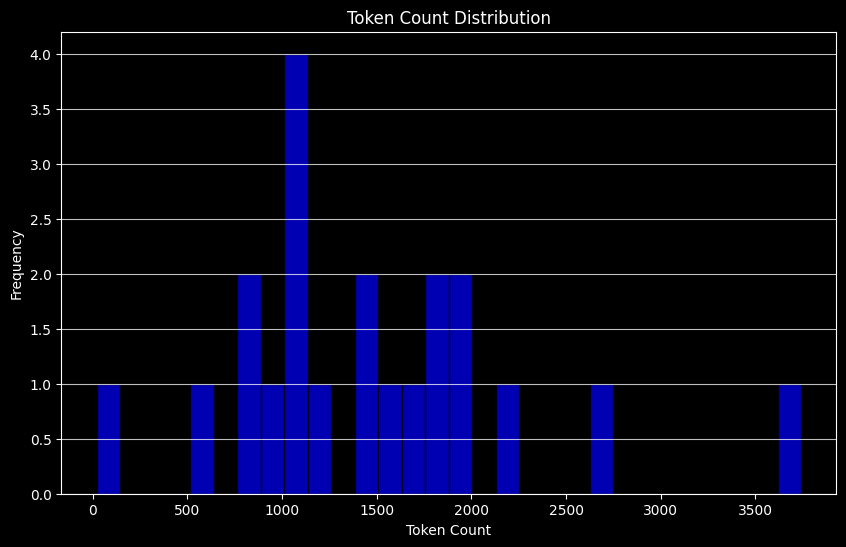

In [7]:
# 문서 텍스트
docs_texts = [d.page_content for d in docs]

# 각 문서에 대한 토큰 수 계산
counts = [num_tokens_from_string(d, "cl100k_base") for d in docs_texts]

# 토큰 수의 히스토그램을 그립니다.
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Token Count Distribution")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)

# 히스토그램을 표시합니다.
plt.show()

## **** Document_Graph_parser ****
- 패캠_주주총회 8월달 내용 참고
- Upstage의 문서 레이아웃 분석 API를 활용하여 다양한 속성을 추출
- 추출된 내용들을 GraphState클래스를 활용하여 적재

In [8]:
from typing import TypedDict

# GraphState 상태를 저장하는 용도로 사용합니다.
class GraphState(TypedDict):
    filepath: str  # path
    filetype: str  # pdf
    page_numbers: list[int]  # page numbers
    batch_size: int  # batch size
    split_filepaths: list[str]  # split files
    analyzed_files: list[str]  # analyzed files
    page_elements: dict[int, dict[str, list[dict]]]  # page elements
    page_metadata: dict[int, dict]  # page metadata
    page_summary: dict[int, str]  # page summary
    images: list[str]  # image paths
    images_summary: list[str]  # image summary
    tables: list[str]  # table
    tables_summary: dict[int, str]  # table summary
    texts: list[str]  # text
    texts_summary: list[str]  # text summary

#### 1. 문서를 배치 단위로 분할 (10 page)
- 페이지수가 많은 문서를 통으로 넣으면 업스테이지 api 활용시 오류 발생 가능

In [9]:
import os
import pymupdf
import json
import requests
from PIL import Image

In [10]:
def split_pdf(state: GraphState):
    """
    입력 PDF를 여러 개의 작은 PDF 파일로 분할합니다.

    :param state: GraphState 객체, PDF 파일 경로와 배치 크기 정보를 포함
    :return: 분할된 PDF 파일 경로 목록을 포함한 GraphState 객체
    """
    # PDF 파일 경로와 배치 크기 추출
    filepath = state["filepath"]
    batch_size = state["batch_size"]

    # PDF 파일 열기
    input_pdf = pymupdf.open(filepath)
    num_pages = len(input_pdf)
    print(f"총 페이지 수: {num_pages}")

    ret = []
    # PDF 분할 작업 시작
    for start_page in range(0, num_pages, batch_size):
        # 배치의 마지막 페이지 계산 (전체 페이지 수를 초과하지 않도록)
        end_page = min(start_page + batch_size, num_pages) - 1

        # 분할된 PDF 파일명 생성
        input_file_basename = os.path.splitext(filepath)[0]
        output_file = f"{input_file_basename}_{start_page:04d}_{end_page:04d}.pdf"
        print(f"분할 PDF 생성: {output_file}")

        # 새로운 PDF 파일 생성 및 페이지 삽입
        with pymupdf.open() as output_pdf:
            output_pdf.insert_pdf(input_pdf, from_page=start_page, to_page=end_page)
            # insert_pdf()는 다른 PDF에서 일부 페이지를 가져와서 현재 PDF에 붙이는 함수
            output_pdf.save(output_file)
            ret.append(output_file)

    # 원본 PDF 파일 닫기
    input_pdf.close()

    # 분할된 PDF 파일 경로 목록을 포함한 GraphState 객체 반환
    return GraphState(split_filepaths=ret)

In [11]:
state = GraphState(filepath=merged_pdf_path, batch_size=10)
state_out = split_pdf(state)
state.update(state_out)
state

총 페이지 수: 21
분할 PDF 생성: merged_PDF/combined_0000_0009.pdf
분할 PDF 생성: merged_PDF/combined_0010_0019.pdf
분할 PDF 생성: merged_PDF/combined_0020_0020.pdf


{'filepath': 'merged_PDF/combined.pdf',
 'batch_size': 10,
 'split_filepaths': ['merged_PDF/combined_0000_0009.pdf',
  'merged_PDF/combined_0010_0019.pdf',
  'merged_PDF/combined_0020_0020.pdf']}

#### 2. Upstage의 문서 레이아웃 분석 API를 호출해서 문서를 element 단위로 분석 및 JSON 파일로 저장

In [12]:
class LayoutAnalyzer:
    def __init__(self, api_key):
        """
        LayoutAnalyzer 클래스의 생성자

        :param api_key: Upstage API 인증을 위한 API 키
        """
        self.api_key = api_key

    def _upstage_layout_analysis(self, input_file):
        """
        Upstage의 레이아웃 분석 API를 호출하여 문서 분석을 수행합니다.

        :param input_file: 분석할 PDF 파일의 경로
        :return: 분석 결과가 저장된 JSON 파일의 경로
        """
        # API 요청 헤더 설정
        headers = {"Authorization": f"Bearer {self.api_key}"}

        # API 요청 데이터 설정 (OCR 비활성화)
        data = {"ocr": False}

        # 분석할 PDF 파일 열기
        files = {"document": open(input_file, "rb")}

        # API 요청 보내기
        response = requests.post(
            "https://api.upstage.ai/v1/document-ai/layout-analysis",
            headers=headers,
            data=data,
            files=files,
        )

        # API 응답 처리 및 결과 저장
        if response.status_code == 200:
            # 분석 결과를 저장할 JSON 파일 경로 생성
            output_file = os.path.splitext(input_file)[0] + ".json"

            # 분석 결과를 JSON 파일로 저장
            with open(output_file, "w", encoding="utf-8") as f:
                json.dump(response.json(), f, ensure_ascii=False)

            return output_file
        else:
            # API 요청이 실패한 경우 예외 발생
            raise ValueError(f"API 요청 실패. 상태 코드: {response.status_code}")

    def execute(self, input_file):
        """
        주어진 입력 파일에 대해 레이아웃 분석을 실행합니다.

        :param input_file: 분석할 PDF 파일의 경로
        :return: 분석 결과가 저장된 JSON 파일의 경로
        """
        return self._upstage_layout_analysis(input_file)

In [13]:
def analyze_layout(state: GraphState):
    # 분할된 PDF 파일 목록을 가져옵니다.
    split_files = state["split_filepaths"]

    # LayoutAnalyzer 객체를 생성합니다. API 키는 환경 변수에서 가져옵니다.
    analyzer = LayoutAnalyzer(os.environ.get("UPSTAGE_API_KEY"))

    # 분석된 파일들의 경로를 저장할 리스트를 초기화합니다.
    analyzed_files = []

    # 각 분할된 PDF 파일에 대해 레이아웃 분석을 수행합니다.
    for file in split_files:
        # 레이아웃 분석을 실행하고 결과 파일 경로를 리스트에 추가합니다.
        analyzed_files.append(analyzer.execute(file))

    # 분석된 파일 경로들을 정렬하여 새로운 GraphState 객체를 생성하고 반환합니다.
    # 정렬은 파일들의 순서를 유지하기 위해 수행됩니다.
    return GraphState(analyzed_files=sorted(analyzed_files))

In [14]:
state_out = analyze_layout(state)
state.update(state_out)
state

##### 분석 결과가 저장된 JSON 파일에는 문서 안의 요소들(텍스트, 표, 이미지 등)의 위치와 유형 정보가 들어 있음 → 나중에 페이지 요약, 테이블 추출 등에 활용할 수 있음 !!!

{'filepath': 'merged_PDF/combined.pdf',
 'batch_size': 10,
 'split_filepaths': ['merged_PDF/combined_0000_0009.pdf',
  'merged_PDF/combined_0010_0019.pdf',
  'merged_PDF/combined_0020_0020.pdf'],
 'analyzed_files': ['merged_PDF/combined_0000_0009.json',
  'merged_PDF/combined_0010_0019.json',
  'merged_PDF/combined_0020_0020.json']}

In [15]:
with open("merged_PDF/combined_0000_0009.json", "r", encoding="utf-8") as f:
    data = json.load(f)

print(data["metadata"])

{'pages': [{'height': 1595, 'page': 1, 'width': 1123}, {'height': 1595, 'page': 2, 'width': 1123}, {'height': 1595, 'page': 3, 'width': 1123}, {'height': 1595, 'page': 4, 'width': 1123}, {'height': 1595, 'page': 5, 'width': 1123}, {'height': 1595, 'page': 6, 'width': 1123}, {'height': 1595, 'page': 7, 'width': 1123}, {'height': 1595, 'page': 8, 'width': 1123}, {'height': 1595, 'page': 9, 'width': 1123}, {'height': 1754, 'page': 10, 'width': 1241}]}


In [16]:
print(data.keys())

dict_keys(['api', 'billed_pages', 'elements', 'html', 'metadata', 'mimetype', 'model', 'text'])


In [17]:
print(data["elements"][50])

{'bounding_box': [{'x': 262, 'y': 679}, {'x': 580, 'y': 679}, {'x': 580, 'y': 705}, {'x': 262, 'y': 705}], 'category': 'heading1', 'html': "<h1 id='50' style='font-size:20px'>국내 주식시장 주요 지수 기간별 수익률</h1>", 'id': 50, 'page': 5, 'text': '국내 주식시장 주요 지수 기간별 수익률'}


In [18]:
print(data["text"])

2025년 7월 28일
키움증권 리서치센터 | 투자전략팀
관세, 매크로, 실적, 3대 이벤트 쏠림 구간
한국 증시는 1) 한-미 상호관세 협상, 2) 7월 FOMC, 3) 7월 미국 ISM
제조업 PMI 및 비농업 고용, 한국 수출, 4) MS, 메타, 아마존 등 미국
M7 실적, 5) 삼성전자, 한화에어로스페이스, HD현대중공업 등 국내
주요기업 실적 이벤트에 영향 받으면서 변동성 장세를 지속할 전망
(주간 코스피 예상 레인지 3,150~3,250pt).
한 -미 협상 결과는 타결 여부보다 상호 관세 인하 폭(기존 25%) 및
자동차 관세의 인하 여부가 관건. 그 결과에 따라 대표적 관세 피해
주인 자동차 뿐만 아니라, 지수 전반에 걸친 하방 경직성에 변화가
생길 것이기에, 관련 뉴스플로우에 대한 주가 민감도는 높아질 전망.
국내에서 반도체 등 관세 피해주, 방산, 조선 등 주도주이자 관세 무
풍 업종들의 실적도 간과할 수 없는 이벤트. 7월 초 잠정실적 발표 이
후 주가 회복력을 보이고 있는 삼성전자의 경우, 주 후반 예정된 컨
퍼런스콜에서의 사업 전망 변화(HBM 3E 퀄 테스트, 미국 관세 충격
등)가 향후 주가 향방의 변수가 될 전망.
| Strategist 한지영
hedge0301@kiwoom.com
| Market/ESG 이성훈
shl076@kiwoom.com

Compliance Notice
-
- 당사는 7월 25일 현재 보고서에 언급된 종목들의 발행주식을 1% 이상 보유하고 있지 않습니다
- 당사는 동 자료를 기관투자자 또는 제 3자에게 사전 제공한 사실이 없습니다.
동 자료에 게시된 내용들은 본인의 의견을 정확하게 반영하고 있으며, 외부의 부당한 압력이나 간섭없이 작성되었음을 확인합니다.
동 자료의 금융투자분석사는 자료 작성일 현재 동 자료상에 언급된 기업들의 금융투자상품 및 권리를 보유하고 있지 않습니다.
-
고 지사항
- 본 조사분석자료는 당사의 리서치센터가 신뢰할 수 있는 자료 및 정보로부터 얻은 것이나, 당사가 그 정확성이나 완전성을

#### 3. Upstage의 문서 레이아웃 분석 API로 얻은 JSON 파일에서 다양한 속성을 추출하여 state 업데이트하기
* (1) 사이즈 속성 추가하기

In [19]:
import re


def extract_start_end_page(filename):
    """
    파일 이름에서 시작 페이지와 끝 페이지 번호를 추출하는 함수입니다.

    :param filename: 분석할 파일의 이름
    :return: 시작 페이지 번호와 끝 페이지 번호를 튜플로 반환
    """
    # 파일 경로에서 파일 이름만 추출
    file_name = os.path.basename(filename)
    # 파일 이름을 '_' 기준으로 분리
    file_name_parts = file_name.split("_")

    if len(file_name_parts) >= 3:
        # 파일 이름의 뒤에서 두 번째 부분에서 숫자를 추출하여 시작 페이지로 설정
        start_page = int(re.findall(r"(\d+)", file_name_parts[-2])[0])
        # 파일 이름의 마지막 부분에서 숫자를 추출하여 끝 페이지로 설정
        end_page = int(re.findall(r"(\d+)", file_name_parts[-1])[0])
    else:
        # 파일 이름 형식이 예상과 다를 경우 기본값 설정
        start_page, end_page = 0, 0

    return start_page, end_page


def extract_page_metadata(state: GraphState):
    """
    분석된 JSON 파일들에서 페이지 메타데이터를 추출하는 함수입니다.

    :param state: 현재의 GraphState 객체
    :return: 페이지 메타데이터가 추가된 새로운 GraphState 객체
    """
    # 분석된 JSON 파일 목록 가져오기
    json_files = state["analyzed_files"]

    # 페이지 메타데이터를 저장할 딕셔너리 초기화
    page_metadata = dict()

    for json_file in json_files:
        # JSON 파일 열기 및 데이터 로드
        with open(json_file, "r", encoding="utf-8") as f:
            data = json.load(f)

        # 파일명에서 시작 페이지 번호 추출
        start_page, _ = extract_start_end_page(json_file)

        # JSON 데이터에서 각 페이지의 메타데이터 추출
        for element in data["metadata"]["pages"]:
            # 원본 페이지 번호
            original_page = int(element["page"])
            # 상대적 페이지 번호 계산 (전체 문서 기준)
            relative_page = start_page + original_page - 1

            # 페이지 크기 정보 추출
            metadata = {
                "size": [
                    int(element["width"]),
                    int(element["height"]),
                ],
            }
            # 상대적 페이지 번호를 키로 하여 메타데이터 저장
            page_metadata[relative_page] = metadata

    # 추출된 페이지 메타데이터로 새로운 GraphState 객체 생성 및 반환
    return GraphState(page_metadata=page_metadata)

In [20]:
state_out = extract_page_metadata(state)
state.update(state_out)
state["page_metadata"]

{0: {'size': [1123, 1595]},
 1: {'size': [1123, 1595]},
 2: {'size': [1123, 1595]},
 3: {'size': [1123, 1595]},
 4: {'size': [1123, 1595]},
 5: {'size': [1123, 1595]},
 6: {'size': [1123, 1595]},
 7: {'size': [1123, 1595]},
 8: {'size': [1123, 1595]},
 9: {'size': [1241, 1754]},
 10: {'size': [1241, 1754]},
 11: {'size': [1241, 1754]},
 12: {'size': [1241, 1754]},
 13: {'size': [1241, 1754]},
 14: {'size': [1241, 1754]},
 15: {'size': [1241, 1754]},
 16: {'size': [1241, 1754]},
 17: {'size': [1241, 1754]},
 18: {'size': [1241, 1754]},
 19: {'size': [1241, 1754]},
 20: {'size': [1241, 1754]}}

In [21]:
state["analyzed_files"]

['merged_PDF/combined_0000_0009.json',
 'merged_PDF/combined_0010_0019.json',
 'merged_PDF/combined_0020_0020.json']

* (2) 페이지별 HTML Element 추출하여 state[page_elements] 에 추가하기
* 여러 PDF 페이지에서 추출된 JSON 파일을 읽고, 거기서 텍스트나 표, 이미지 등의 요소를 페이지별로 정리해주는 함수

In [22]:
def extract_page_elements(state: GraphState):
    # 분석된 JSON 파일 목록을 가져옵니다.
    json_files = state["analyzed_files"]

    # 페이지별 요소를 저장할 딕셔너리를 초기화합니다.
    page_elements = dict()

    # 전체 문서에서 고유한 요소 ID를 부여하기 위한 카운터입니다.
    element_id = 0

    # 각 JSON 파일을 순회하며 처리합니다.
    for json_file in json_files:
        # 파일명에서 시작 페이지 번호를 추출합니다.
        start_page, _ = extract_start_end_page(json_file)

        # JSON 파일을 열어 데이터를 로드합니다.
        with open(json_file, "r", encoding="utf-8") as f:
            data = json.load(f)

        # JSON 데이터의 각 요소를 처리합니다.
        # Json elements: 'bounding_box', 'category', 'html', 'id', 'page', 'text'
        for element in data["elements"]:
            # 원본 페이지 번호를 정수로 변환합니다.
            original_page = int(element["page"])
            # 전체 문서 기준의 상대적 페이지 번호를 계산합니다.
            relative_page = start_page + original_page - 1

            # 해당 페이지의 요소 리스트가 없으면 새로 생성합니다.
            if relative_page not in page_elements:
                page_elements[relative_page] = []

            # 요소에 고유 ID를 부여합니다.
            element["id"] = element_id
            element_id += 1

            # 요소의 페이지 번호를 상대적 페이지 번호로 업데이트합니다.
            element["page"] = relative_page
            # 요소를 해당 페이지의 리스트에 추가합니다.
            page_elements[relative_page].append(element)

    # 추출된 페이지별 요소 정보로 새로운 GraphState 객체를 생성하여 반환합니다.
    return GraphState(page_elements=page_elements)

In [23]:
state_out = extract_page_elements(state)
state.update(state_out)
state["page_elements"][0]

[{'bounding_box': [{'x': 402, 'y': 295},
   {'x': 668, 'y': 295},
   {'x': 668, 'y': 351},
   {'x': 402, 'y': 351}],
  'category': 'paragraph',
  'html': "<p id='0' data-category='paragraph' style='font-size:20px'>2025년 7월 28일<br>키움증권 리서치센터 | 투자전략팀</p>",
  'id': 0,
  'page': 0,
  'text': '2025년 7월 28일\n키움증권 리서치센터 | 투자전략팀'},
 {'bounding_box': [{'x': 413, 'y': 495},
   {'x': 903, 'y': 495},
   {'x': 903, 'y': 529},
   {'x': 413, 'y': 529}],
  'category': 'heading1',
  'html': "<h1 id='1' style='font-size:22px'>관세, 매크로, 실적, 3대 이벤트 쏠림 구간</h1>",
  'id': 1,
  'page': 0,
  'text': '관세, 매크로, 실적, 3대 이벤트 쏠림 구간'},
 {'bounding_box': [{'x': 408, 'y': 545},
   {'x': 960, 'y': 545},
   {'x': 960, 'y': 688},
   {'x': 408, 'y': 688}],
  'category': 'paragraph',
  'html': "<br><p id='2' data-category='paragraph' style='font-size:20px'>한국 증시는 1) 한-미 상호관세 협상, 2) 7월 FOMC, 3) 7월 미국 ISM<br>제조업 PMI 및 비농업 고용, 한국 수출, 4) MS, 메타, 아마존 등 미국<br>M7 실적, 5) 삼성전자, 한화에어로스페이스, HD현대중공업 등 국내<br>주요기업 실적 이벤트에 영향 받으면서 변동성 장세를 

In [24]:
state["page_elements"][5]

[{'bounding_box': [{'x': 270, 'y': 140},
   {'x': 406, 'y': 140},
   {'x': 406, 'y': 194},
   {'x': 270, 'y': 194}],
  'category': 'paragraph',
  'html': "<p id='54' data-category='paragraph' style='font-size:18px'>2025년 7월 28일<br>KIWOOM WEEKLY</p>",
  'id': 54,
  'page': 5,
  'text': '2025년 7월 28일\nKIWOOM WEEKLY'},
 {'bounding_box': [{'x': 99, 'y': 197},
   {'x': 319, 'y': 197},
   {'x': 319, 'y': 223},
   {'x': 99, 'y': 223}],
  'category': 'heading1',
  'html': "<br><h1 id='55' style='font-size:22px'>KOSPI 업종별 주간 등락률</h1>",
  'id': 55,
  'page': 5,
  'text': 'KOSPI 업종별 주간 등락률'},
 {'bounding_box': [{'x': 100, 'y': 232},
   {'x': 1039, 'y': 232},
   {'x': 1039, 'y': 542},
   {'x': 100, 'y': 542}],
  'category': 'chart',
  'html': '<figure id=\'56\' data-category=\'chart\'><img data-coord="top-left:(100,232); bottom-right:(1039,542)" /></figure>',
  'id': 56,
  'page': 5,
  'text': ''},
 {'bounding_box': [{'x': 99, 'y': 551},
   {'x': 334, 'y': 551},
   {'x': 334, 'y': 575},
   {'x': 9

In [25]:
state["page_elements"].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

* (3) page_elements를 category(figure, table, chart, 그외)별로 분해하여 새로운 딕셔너리 변수에 담기

In [26]:
def extract_tag_elements_per_page(state: GraphState):
    # GraphState 객체에서 페이지 요소들을 가져옵니다.
    page_elements = state["page_elements"]

    # 파싱된 페이지 요소들을 저장할 새로운 딕셔너리를 생성합니다.
    parsed_page_elements = dict()

    # 각 페이지와 해당 페이지의 요소들을 순회합니다.
    for key, page_element in page_elements.items():
        # 이미지, 테이블, 텍스트 요소들을 저장할 리스트를 초기화합니다.
        image_elements = []
        table_elements = []
        text_elements = []
        chart_elements = []

        # 페이지의 각 요소를 순회하며 카테고리별로 분류합니다.
        for element in page_element:
            if element["category"] == "figure":
                # 이미지 요소인 경우 image_elements 리스트에 추가합니다.
                image_elements.append(element)
            elif element["category"] == "table":
                # 테이블 요소인 경우 table_elements 리스트에 추가합니다.
                table_elements.append(element)
            elif element["category"] == "chart":
                # 테이블 요소인 경우 table_elements 리스트에 추가합니다.
                chart_elements.append(element)
            else:
                # 그 외의 요소는 모두 텍스트 요소로 간주하여 text_elements 리스트에 추가합니다.
                text_elements.append(element)

        # 분류된 요소들을 페이지 키와 함께 새로운 딕셔너리에 저장합니다.
        parsed_page_elements[key] = {
            "image_elements": image_elements,
            "table_elements": table_elements,
            "chart_elements": chart_elements,
            "text_elements": text_elements,
            "elements": page_element,  # 원본 페이지 요소도 함께 저장합니다.
        }

    # 파싱된 페이지 요소들을 포함한 새로운 GraphState 객체를 반환합니다.
    return GraphState(page_elements=parsed_page_elements)

In [27]:
state_out = extract_tag_elements_per_page(state)
state.update(state_out)

In [28]:
state["page_elements"][0].keys()

dict_keys(['image_elements', 'table_elements', 'chart_elements', 'text_elements', 'elements'])

In [29]:
state["page_elements"][0]["image_elements"]

[{'bounding_box': [{'x': 573, 'y': 1051},
   {'x': 782, 'y': 1051},
   {'x': 782, 'y': 1240},
   {'x': 573, 'y': 1240}],
  'category': 'figure',
  'html': '<figure id=\'4\'><img style=\'font-size:18px\' alt="| Strategist 한지영\nhedge0301@kiwoom.com" data-coord="top-left:(573,1051); bottom-right:(782,1240)" /></figure>',
  'id': 4,
  'page': 0,
  'text': '| Strategist 한지영\nhedge0301@kiwoom.com'},
 {'bounding_box': [{'x': 931, 'y': 1061},
   {'x': 1010, 'y': 1061},
   {'x': 1010, 'y': 1191},
   {'x': 931, 'y': 1191}],
  'category': 'figure',
  'html': '<br><figure id=\'6\'><img alt="" data-coord="top-left:(931,1061); bottom-right:(1010,1191)" /></figure>',
  'id': 6,
  'page': 0,
  'text': ''}]

In [30]:
state_out["page_elements"][2]["table_elements"]

[{'bounding_box': [{'x': 100, 'y': 255},
   {'x': 1046, 'y': 255},
   {'x': 1046, 'y': 1168},
   {'x': 100, 'y': 1168}],
  'category': 'table',
  'html': "<br><table id='29' style='font-size:16px'><thead><tr><td></td><td>국가</td><td>경제지표</td><td>대상</td><td>전망치</td><td>이전치</td></tr></thead><tbody><tr><td>7 월 28 일</td><td>월 미국 실적</td><td>댈러스 연준 제조업 활동 현대오토에버, 두산로보틱스</td><td>7 월</td><td>-</td><td>-12.7</td></tr><tr><td>7 월 29 일</td><td>화 미국 실적 실적</td><td>CB 소비자기대지수 JOLTs 구인건수 한화오션, 한화시스템, 한국항공우주, 크래프톤 비자, 유나이티드헬스, 보잉, 페이팔</td><td>7 월 6 월</td><td>95.9 -</td><td>93.0 7,769K</td></tr><tr><td>7 월 30 일</td><td>수 미국</td><td>GDP 성장률 (QoQ,잠정치) ADP 취업자 변동수</td><td>2 분기 7 월</td><td>2.5% 75K</td><td>-0.5% -33K</td></tr><tr><td></td><td>유로존 회의 실적</td><td>GDP 성장률 (YoY,잠정치) FOMC 회의</td><td>2 분기</td><td>- 4.25-4.50%</td><td>1.5% 4.25-4.50%</td></tr><tr><td>7 월 31 일</td><td>실적 목 미국</td><td>삼성물산, SKC 마이크로소프트, 메타, 퀄컴 PCE 물가 (YoY)</td><td>6 월</td><td>2.5%</td><td>2.3%</td></tr><tr><td></td><td></td><td>근원 PC

In [31]:
state["page_elements"][2]["text_elements"]

[{'bounding_box': [{'x': 270, 'y': 140},
   {'x': 405, 'y': 140},
   {'x': 405, 'y': 194},
   {'x': 270, 'y': 194}],
  'category': 'paragraph',
  'html': "<p id='27' data-category='paragraph' style='font-size:14px'>2025년 7월 28일<br>KIWOOM WEEKLY</p>",
  'id': 27,
  'page': 2,
  'text': '2025년 7월 28일\nKIWOOM WEEKLY'},
 {'bounding_box': [{'x': 100, 'y': 219},
   {'x': 368, 'y': 219},
   {'x': 368, 'y': 243},
   {'x': 100, 'y': 243}],
  'category': 'heading1',
  'html': "<h1 id='28' style='font-size:20px'>이번 주 주요 경제지표 발표 일정</h1>",
  'id': 28,
  'page': 2,
  'text': '이번 주 주요 경제지표 발표 일정'},
 {'bounding_box': [{'x': 99, 'y': 1175},
   {'x': 355, 'y': 1175},
   {'x': 355, 'y': 1195},
   {'x': 99, 'y': 1195}],
  'category': 'paragraph',
  'html': "<br><p id='30' data-category='paragraph' style='font-size:14px'>출 처: Bloomberg, 키움증권 리서치센터</p>",
  'id': 30,
  'page': 2,
  'text': '출 처: Bloomberg, 키움증권 리서치센터'},
 {'bounding_box': [{'x': 1021, 'y': 1517},
   {'x': 1036, 'y': 1517},
   {'x': 1036, 'y':

In [32]:
state["page_elements"][4]

{'image_elements': [],
 'table_elements': [{'bounding_box': [{'x': 263, 'y': 714},
    {'x': 1039, 'y': 714},
    {'x': 1039, 'y': 1094},
    {'x': 263, 'y': 1094}],
   'category': 'table',
   'html': '<br><table id=\'51\' style=\'font-size:16px\'><thead><tr><td rowspan="2">시장</td><td rowspan="2">종가(pt)</td><td colspan="4">기간별 수익률</td></tr><tr><td>D-1(%)</td><td>D-5(%)</td><td>D-20(%)</td><td>YTD(%)</td></tr></thead><tbody><tr><td>코스피</td><td>3,196.05</td><td>0.2</td><td>0.3</td><td>2.8</td><td>33.2</td></tr><tr><td>대형주</td><td>3,194.26</td><td>0.2</td><td>0.5</td><td>2.9</td><td>33.7</td></tr><tr><td>중형주</td><td>3,548.69</td><td>-0.2</td><td>-0.3</td><td>3.8</td><td>33.5</td></tr><tr><td>소형주</td><td>2,522.37</td><td>-0.2</td><td>-2.7</td><td>0.5</td><td>20.5</td></tr><tr><td>코스피 200</td><td>430.78</td><td>0.2</td><td>-0.1</td><td>2.7</td><td>35.5</td></tr><tr><td>코스닥</td><td>806.95</td><td>-0.4</td><td>-1.7</td><td>1.1</td><td>19.0</td></tr><tr><td>대형주</td><td>1,933.92</td><td>-0.8</t

In [33]:
state["page_elements"][0]["elements"][2]["category"]

'paragraph'

In [34]:
state["page_elements"][1]["elements"]

[{'bounding_box': [{'x': 271, 'y': 142},
   {'x': 395, 'y': 142},
   {'x': 395, 'y': 164},
   {'x': 271, 'y': 164}],
  'category': 'heading1',
  'html': "<h1 id='13' style='font-size:16px'>2025년 7월 28일</h1>",
  'id': 13,
  'page': 1,
  'text': '2025년 7월 28일'},
 {'bounding_box': [{'x': 271, 'y': 172},
   {'x': 404, 'y': 172},
   {'x': 404, 'y': 192},
   {'x': 271, 'y': 192}],
  'category': 'paragraph',
  'html': "<br><p id='14' data-category='paragraph' style='font-size:16px'>KIWOOM WEEKLY</p>",
  'id': 14,
  'page': 1,
  'text': 'KIWOOM WEEKLY'},
 {'bounding_box': [{'x': 277, 'y': 208},
   {'x': 582, 'y': 208},
   {'x': 582, 'y': 244},
   {'x': 277, 'y': 244}],
  'category': 'heading1',
  'html': "<br><h1 id='15' style='font-size:22px'>1. 지난 주 주식시장 동향</h1>",
  'id': 15,
  'page': 1,
  'text': '1. 지난 주 주식시장 동향'},
 {'bounding_box': [{'x': 271, 'y': 260},
   {'x': 1038, 'y': 260},
   {'x': 1038, 'y': 345},
   {'x': 271, 'y': 345}],
  'category': 'paragraph',
  'html': "<br><p id='16' data

In [35]:
### 카테고리의 종류 보기
def extract_unique_categories(state: GraphState) -> set[str]:

    unique_categories = set()

    for page_elements in state.get("page_elements", {}).values():

        elements = page_elements.get("elements", [])

        for elem in elements:

            category = elem.get("category")

            if category is not None:

                unique_categories.add(category)

    return unique_categories


unique_cats = extract_unique_categories(state)


print("카테고리 종류:", unique_cats)

카테고리 종류: {'header', 'footer', 'heading1', 'list', 'paragraph', 'table', 'caption', 'figure', 'footnote', 'chart'}


* (4) 페이지 번호 추가하기

In [36]:
def page_numbers(state: GraphState):
    return GraphState(page_numbers=list(state["page_elements"].keys()))


state_out = page_numbers(state)
state.update(state_out)
state["page_numbers"]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

* (5) 이미지를 png파일로 추출하여 저장하기
- 🔁 전체 흐름 요약
- PDF 한 페이지 → 이미지로 변환 → 그림/표 요소의 좌표로 자르기 → PNG로 저장 → 경로 기록
- [PDF 파일 전체]
    -    ↓ (page_numbers: 예를 들어 [0, 1, 2, 3])
- [모든 페이지에 대해 반복]
    -    ↓
- [pymupdf로 → 이미지(PIL.Image)로 변환]
    -    ↓
- [그 페이지 안의 image_elements 또는 table_elements를 하나씩 확인]
    -    ↓
- [해당 bounding box 기준으로 자름]
    -    ↓
- [잘라낸 이미지 PNG로 저장]

In [37]:
class ImageCropper:
    @staticmethod
    def pdf_to_image(pdf_file, page_num, dpi=300):
        """
        PDF 파일의 특정 페이지를 이미지로 변환하는 메서드

        :param page_num: 변환할 페이지 번호 (1부터 시작)
        :param dpi: 이미지 해상도 (기본값: 300)
        :return: 변환된 이미지 객체
                        🔁 요약 흐름
                        PDF → 이미지 → (좌표 정규화) → 이미지 자르기 → 저장
        """
        with pymupdf.open(pdf_file) as doc:
            page = doc[page_num].get_pixmap(dpi=dpi)
            target_page_size = [page.width, page.height]
            page_img = Image.frombytes("RGB", target_page_size, page.samples)
        return page_img

    @staticmethod
    def normalize_coordinates(coordinates, output_page_size):
        """
        좌표를 정규화하는 정적 메서드

        :param coordinates: 원본 좌표 리스트
        :param output_page_size: 출력 페이지 크기 [너비, 높이]
        :return: 정규화된 좌표 (x1, y1, x2, y2)
        """
        x_values = [coord["x"] for coord in coordinates]
        y_values = [coord["y"] for coord in coordinates]
        x1, y1, x2, y2 = min(x_values), min(y_values), max(x_values), max(y_values)

        return (
            x1 / output_page_size[0],
            y1 / output_page_size[1],
            x2 / output_page_size[0],
            y2 / output_page_size[1],
        )

    @staticmethod
    def crop_image(img, coordinates, output_file):
        """
        이미지를 주어진 좌표에 따라 자르고 저장하는 정적 메서드

        :param img: 원본 이미지 객체
        :param coordinates: 정규화된 좌표 (x1, y1, x2, y2)
        :param output_file: 저장할 파일 경로
        """
        img_width, img_height = img.size
        x1, y1, x2, y2 = [
            int(coord * dim)
            for coord, dim in zip(coordinates, [img_width, img_height] * 2)
        ]
        cropped_img = img.crop((x1, y1, x2, y2))
        cropped_img.save(output_file)

* @staticmethod 는 클래스와 논리적으로는 연결되지만, 인스턴스/클래스 상태와 독립적으로 동작하는 유틸성 함수를 만들 때 쓰는 도구
* 사용 예시
  - 클래스 메서드 호출
  - ImageCropper.pdf_to_image("file.pdf", 0)

  - 인스턴스 생성 후 호출도 가능하지만 self 전달 안됨
  - cropper = ImageCropper()
  - cropper.pdf_to_image("file.pdf", 0)

In [38]:
def crop_image(state: GraphState):
    """
    PDF 파일에서 이미지를 추출하고 크롭하는 함수
    :param state: GraphState 객체
    :return: 크롭된 이미지 정보가 포함된 GraphState 객체
    """
    pdf_file = state["filepath"]  # PDF 파일 경로
    page_numbers = state["page_numbers"]  # 처리할 페이지 번호 목록
    output_folder = os.path.splitext(pdf_file)[0]  # 출력 폴더 경로 설정
    os.makedirs(output_folder, exist_ok=True)  # 출력 폴더 생성
    cropped_images = dict()  # 크롭된 이미지 정보를 저장할 딕셔너리
    for page_num in page_numbers:
        pdf_image = ImageCropper.pdf_to_image(
            pdf_file, page_num
        )  # PDF 페이지를 이미지로 변환

        for element in state["page_elements"][page_num]["image_elements"]:
            if element["category"] == "figure":
                # 이미지 요소의 좌표를 정규화
                normalized_coordinates = ImageCropper.normalize_coordinates(
                    element["bounding_box"], state["page_metadata"][page_num]["size"]
                )
                # 크롭된 이미지 저장 경로 설정
                output_file = os.path.join(output_folder, f"{element['id']}.png")
                # 이미지 크롭 및 저장
                ImageCropper.crop_image(pdf_image, normalized_coordinates, output_file)
                cropped_images[element["id"]] = output_file
                print(f"page:{page_num}, id:{element['id']}, path: {output_file}")

    return GraphState(
        images=cropped_images
    )  # 크롭된 이미지 정보를 포함한 GraphState 반환


def crop_table(state: GraphState):
    """
    PDF 파일에서 표를 추출하고 크롭하는 함수
    :param state: GraphState 객체
    :return: 크롭된 표 이미지 정보가 포함된 GraphState 객체
    """
    pdf_file = state["filepath"]  # PDF 파일 경로
    page_numbers = state["page_numbers"]  # 처리할 페이지 번호 목록
    output_folder = os.path.splitext(pdf_file)[0]  # 출력 폴더 경로 설정
    os.makedirs(output_folder, exist_ok=True)  # 출력 폴더 생성
    cropped_images = dict()  # 크롭된 표 이미지 정보를 저장할 딕셔너리
    for page_num in page_numbers:
        pdf_image = ImageCropper.pdf_to_image(
            pdf_file, page_num
        )  # PDF 페이지를 이미지로 변환

        for element in state["page_elements"][page_num]["table_elements"]:
            if element["category"] == "table":
                # 표 요소의 좌표를 정규화
                normalized_coordinates = ImageCropper.normalize_coordinates(
                    element["bounding_box"], state["page_metadata"][page_num]["size"]
                )
                # 크롭된 표 이미지 저장 경로 설정
                output_file = os.path.join(output_folder, f"{element['id']}.png")
                # 표 이미지 크롭 및 저장
                ImageCropper.crop_image(pdf_image, normalized_coordinates, output_file)
                cropped_images[element["id"]] = output_file
                print(f"page:{page_num}, id:{element['id']}, path: {output_file}")

    return GraphState(
        tables=cropped_images
    )  # 크롭된 표 이미지 정보를 포함한 GraphState 반환

In [39]:
def crop_chart(state: GraphState):
    """
    PDF 파일에서 차트를 추출하고 크롭하는 함수
    :param state: GraphState 객체
    :return: 크롭된 차트 이미지 정보가 포함된 GraphState 객체
    """
    pdf_file = state["filepath"]  # PDF 파일 경로
    page_numbers = state["page_numbers"]  # 처리할 페이지 번호 목록
    output_folder = os.path.splitext(pdf_file)[0]  # 출력 폴더 경로 설정
    os.makedirs(output_folder, exist_ok=True)  # 출력 폴더 생성
    cropped_images = dict()  # 크롭된 표 이미지 정보를 저장할 딕셔너리
    for page_num in page_numbers:
        pdf_image = ImageCropper.pdf_to_image(
            pdf_file, page_num
        )  # PDF 페이지를 이미지로 변환

        for element in state["page_elements"][page_num]["chart_elements"]:
            if element["category"] == "chart":
                # 표 요소의 좌표를 정규화
                normalized_coordinates = ImageCropper.normalize_coordinates(
                    element["bounding_box"], state["page_metadata"][page_num]["size"]
                )
                # 크롭된 표 이미지 저장 경로 설정
                output_file = os.path.join(output_folder, f"{element['id']}.png")
                # 표 이미지 크롭 및 저장
                ImageCropper.crop_image(pdf_image, normalized_coordinates, output_file)
                cropped_images[element["id"]] = output_file
                print(f"page:{page_num}, id:{element['id']}, path: {output_file}")

    return GraphState(
        chart=cropped_images
    )  # 크롭된 표 이미지 정보를 포함한 GraphState 반환

In [40]:
state_out = crop_image(state)
state.update(state_out)
state["images"]

page:0, id:4, path: merged_PDF/combined\4.png
page:0, id:6, path: merged_PDF/combined\6.png
page:14, id:236, path: merged_PDF/combined\236.png
page:16, id:311, path: merged_PDF/combined\311.png
page:16, id:313, path: merged_PDF/combined\313.png


{4: 'merged_PDF/combined\\4.png',
 6: 'merged_PDF/combined\\6.png',
 236: 'merged_PDF/combined\\236.png',
 311: 'merged_PDF/combined\\311.png',
 313: 'merged_PDF/combined\\313.png'}

In [41]:
state_out = crop_table(state)
state.update(state_out)
state["tables"]

page:2, id:29, path: merged_PDF/combined\29.png
page:4, id:51, path: merged_PDF/combined\51.png
page:9, id:102, path: merged_PDF/combined\102.png
page:9, id:104, path: merged_PDF/combined\104.png
page:9, id:106, path: merged_PDF/combined\106.png
page:9, id:107, path: merged_PDF/combined\107.png
page:12, id:206, path: merged_PDF/combined\206.png
page:14, id:249, path: merged_PDF/combined\249.png
page:16, id:319, path: merged_PDF/combined\319.png
page:16, id:322, path: merged_PDF/combined\322.png
page:16, id:325, path: merged_PDF/combined\325.png
page:17, id:336, path: merged_PDF/combined\336.png
page:17, id:338, path: merged_PDF/combined\338.png
page:17, id:340, path: merged_PDF/combined\340.png
page:18, id:345, path: merged_PDF/combined\345.png
page:18, id:347, path: merged_PDF/combined\347.png
page:19, id:364, path: merged_PDF/combined\364.png
page:19, id:367, path: merged_PDF/combined\367.png
page:19, id:372, path: merged_PDF/combined\372.png
page:19, id:374, path: merged_PDF/combine

{29: 'merged_PDF/combined\\29.png',
 51: 'merged_PDF/combined\\51.png',
 102: 'merged_PDF/combined\\102.png',
 104: 'merged_PDF/combined\\104.png',
 106: 'merged_PDF/combined\\106.png',
 107: 'merged_PDF/combined\\107.png',
 206: 'merged_PDF/combined\\206.png',
 249: 'merged_PDF/combined\\249.png',
 319: 'merged_PDF/combined\\319.png',
 322: 'merged_PDF/combined\\322.png',
 325: 'merged_PDF/combined\\325.png',
 336: 'merged_PDF/combined\\336.png',
 338: 'merged_PDF/combined\\338.png',
 340: 'merged_PDF/combined\\340.png',
 345: 'merged_PDF/combined\\345.png',
 347: 'merged_PDF/combined\\347.png',
 364: 'merged_PDF/combined\\364.png',
 367: 'merged_PDF/combined\\367.png',
 372: 'merged_PDF/combined\\372.png',
 374: 'merged_PDF/combined\\374.png',
 378: 'merged_PDF/combined\\378.png',
 380: 'merged_PDF/combined\\380.png'}

In [42]:
state_out = crop_chart(state)
state.update(state_out)
state["chart"]

page:1, id:24, path: merged_PDF/combined\24.png
page:5, id:56, path: merged_PDF/combined\56.png
page:5, id:59, path: merged_PDF/combined\59.png
page:5, id:62, path: merged_PDF/combined\62.png
page:5, id:66, path: merged_PDF/combined\66.png
page:6, id:72, path: merged_PDF/combined\72.png
page:6, id:75, path: merged_PDF/combined\75.png
page:6, id:78, path: merged_PDF/combined\78.png
page:6, id:81, path: merged_PDF/combined\81.png
page:7, id:87, path: merged_PDF/combined\87.png
page:7, id:90, path: merged_PDF/combined\90.png
page:7, id:93, path: merged_PDF/combined\93.png
page:10, id:130, path: merged_PDF/combined\130.png
page:10, id:133, path: merged_PDF/combined\133.png
page:10, id:136, path: merged_PDF/combined\136.png
page:10, id:139, path: merged_PDF/combined\139.png
page:10, id:142, path: merged_PDF/combined\142.png
page:10, id:145, path: merged_PDF/combined\145.png
page:10, id:148, path: merged_PDF/combined\148.png
page:10, id:151, path: merged_PDF/combined\151.png
page:11, id:156,

{24: 'merged_PDF/combined\\24.png',
 56: 'merged_PDF/combined\\56.png',
 59: 'merged_PDF/combined\\59.png',
 62: 'merged_PDF/combined\\62.png',
 66: 'merged_PDF/combined\\66.png',
 72: 'merged_PDF/combined\\72.png',
 75: 'merged_PDF/combined\\75.png',
 78: 'merged_PDF/combined\\78.png',
 81: 'merged_PDF/combined\\81.png',
 87: 'merged_PDF/combined\\87.png',
 90: 'merged_PDF/combined\\90.png',
 93: 'merged_PDF/combined\\93.png',
 130: 'merged_PDF/combined\\130.png',
 133: 'merged_PDF/combined\\133.png',
 136: 'merged_PDF/combined\\136.png',
 139: 'merged_PDF/combined\\139.png',
 142: 'merged_PDF/combined\\142.png',
 145: 'merged_PDF/combined\\145.png',
 148: 'merged_PDF/combined\\148.png',
 151: 'merged_PDF/combined\\151.png',
 156: 'merged_PDF/combined\\156.png',
 160: 'merged_PDF/combined\\160.png',
 164: 'merged_PDF/combined\\164.png',
 165: 'merged_PDF/combined\\165.png',
 168: 'merged_PDF/combined\\168.png',
 172: 'merged_PDF/combined\\172.png',
 176: 'merged_PDF/combined\\176.png'

* (6) 페이지마다 텍스트 추출하여 state 속성으로 추가하기

In [43]:
state["page_elements"][4]

{'image_elements': [],
 'table_elements': [{'bounding_box': [{'x': 263, 'y': 714},
    {'x': 1039, 'y': 714},
    {'x': 1039, 'y': 1094},
    {'x': 263, 'y': 1094}],
   'category': 'table',
   'html': '<br><table id=\'51\' style=\'font-size:16px\'><thead><tr><td rowspan="2">시장</td><td rowspan="2">종가(pt)</td><td colspan="4">기간별 수익률</td></tr><tr><td>D-1(%)</td><td>D-5(%)</td><td>D-20(%)</td><td>YTD(%)</td></tr></thead><tbody><tr><td>코스피</td><td>3,196.05</td><td>0.2</td><td>0.3</td><td>2.8</td><td>33.2</td></tr><tr><td>대형주</td><td>3,194.26</td><td>0.2</td><td>0.5</td><td>2.9</td><td>33.7</td></tr><tr><td>중형주</td><td>3,548.69</td><td>-0.2</td><td>-0.3</td><td>3.8</td><td>33.5</td></tr><tr><td>소형주</td><td>2,522.37</td><td>-0.2</td><td>-2.7</td><td>0.5</td><td>20.5</td></tr><tr><td>코스피 200</td><td>430.78</td><td>0.2</td><td>-0.1</td><td>2.7</td><td>35.5</td></tr><tr><td>코스닥</td><td>806.95</td><td>-0.4</td><td>-1.7</td><td>1.1</td><td>19.0</td></tr><tr><td>대형주</td><td>1,933.92</td><td>-0.8</t

In [44]:
state.keys()

dict_keys(['filepath', 'batch_size', 'split_filepaths', 'analyzed_files', 'page_metadata', 'page_elements', 'page_numbers', 'images', 'tables', 'chart'])

In [45]:
state["page_elements"][4].keys()

dict_keys(['image_elements', 'table_elements', 'chart_elements', 'text_elements', 'elements'])

In [46]:
state["page_elements"][4]["text_elements"]

[{'bounding_box': [{'x': 271, 'y': 143},
   {'x': 395, 'y': 143},
   {'x': 395, 'y': 163},
   {'x': 271, 'y': 163}],
  'category': 'heading1',
  'html': "<h1 id='45' style='font-size:14px'>2025년 7월 28일</h1>",
  'id': 45,
  'page': 4,
  'text': '2025년 7월 28일'},
 {'bounding_box': [{'x': 271, 'y': 172},
   {'x': 404, 'y': 172},
   {'x': 404, 'y': 192},
   {'x': 271, 'y': 192}],
  'category': 'paragraph',
  'html': "<br><p id='46' data-category='paragraph' style='font-size:14px'>KIWOOM WEEKLY</p>",
  'id': 46,
  'page': 4,
  'text': 'KIWOOM WEEKLY'},
 {'bounding_box': [{'x': 268, 'y': 196},
   {'x': 1038, 'y': 196},
   {'x': 1038, 'y': 281},
   {'x': 268, 'y': 281}],
  'category': 'paragraph',
  'html': "<br><p id='47' data-category='paragraph' style='font-size:20px'>난주 알파벳 실적, 트럼프의 AI 액션플랜에서 유추할 수 있듯이, 관세 무풍이자 투자 모멘텀이<br>유효한 MS 등 AI주들의 실적 모멘텀은 훼손되지 않을 전망. 이는 추후에도 관세, 매크로 불확실<br>성이 상존하는 미국 증시의 하단을 지지해 주는 버팀목이 될 것으로 예상.</p>",
  'id': 47,
  'page': 4,
  'text': '난주 알파벳 실적, 트럼프의 AI 액션플랜에서 유추할

In [46]:
def extract_page_text(state: GraphState):
    # 상태 객체에서 페이지 번호 목록을 가져옵니다.
    page_numbers = state["page_numbers"]

    # 추출된 텍스트를 저장할 딕셔너리를 초기화합니다.
    extracted_texts = dict()

    # 각 페이지 번호에 대해 반복합니다.
    for page_num in page_numbers:
        # 현재 페이지의 텍스트를 저장할 빈 문자열을 초기화합니다.
        extracted_texts[page_num] = ""

        # 현재 페이지의 모든 텍스트 요소에 대해 반복합니다.
        for element in state["page_elements"][page_num]["text_elements"]:
            # 각 텍스트 요소의 내용을 현재 페이지의 텍스트에 추가합니다.
            extracted_texts[page_num] += element["text"]

    # 추출된 텍스트를 포함한 새로운 GraphState 객체를 반환합니다.
    return GraphState(texts=extracted_texts)

In [47]:
state_out = extract_page_text(state)
state.update(state_out)
state["texts"].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

In [48]:
print(state.keys())

dict_keys(['filepath', 'batch_size', 'split_filepaths', 'analyzed_files', 'page_metadata', 'page_elements', 'page_numbers', 'images', 'tables', 'chart', 'texts'])


In [49]:
import pprint

pprint.pprint(state["page_elements"][20])

{'chart_elements': [],
 'elements': [{'bounding_box': [{'x': 306, 'y': 68},
                                {'x': 653, 'y': 68},
                                {'x': 653, 'y': 94},
                                {'x': 306, 'y': 94}],
               'category': 'header',
               'html': "<header id='0' style='font-size:18px'>2025 년 7 월 28 일 "
                       'Kiwoom ETF Weekly</header>',
               'id': 376,
               'page': 20,
               'text': '2025 년 7 월 28 일 Kiwoom ETF Weekly'},
              {'bounding_box': [{'x': 85, 'y': 154},
                                {'x': 347, 'y': 154},
                                {'x': 347, 'y': 178},
                                {'x': 85, 'y': 178}],
               'category': 'paragraph',
               'html': "<p id='1' data-category='paragraph' "
                       "style='font-size:20px'>국 내 ETF 주간 자금유입 Top10</p>",
               'id': 377,
               'page': 20,
               'text': '국 내 ETF 주간 

In [50]:
pprint.pprint(state["tables"])

{29: 'merged_PDF/combined\\29.png',
 51: 'merged_PDF/combined\\51.png',
 102: 'merged_PDF/combined\\102.png',
 104: 'merged_PDF/combined\\104.png',
 106: 'merged_PDF/combined\\106.png',
 107: 'merged_PDF/combined\\107.png',
 206: 'merged_PDF/combined\\206.png',
 249: 'merged_PDF/combined\\249.png',
 319: 'merged_PDF/combined\\319.png',
 322: 'merged_PDF/combined\\322.png',
 325: 'merged_PDF/combined\\325.png',
 336: 'merged_PDF/combined\\336.png',
 338: 'merged_PDF/combined\\338.png',
 340: 'merged_PDF/combined\\340.png',
 345: 'merged_PDF/combined\\345.png',
 347: 'merged_PDF/combined\\347.png',
 364: 'merged_PDF/combined\\364.png',
 367: 'merged_PDF/combined\\367.png',
 372: 'merged_PDF/combined\\372.png',
 374: 'merged_PDF/combined\\374.png',
 378: 'merged_PDF/combined\\378.png',
 380: 'merged_PDF/combined\\380.png'}


* (7) 텍스트 요약본을 활용하여 이미지와 테이블의 내용을 요약하여 state 속성에 추가하기

* (7-1) 텍스트 요약 추가하기

In [51]:
### 텍스트 요약 추가하기 ###
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain.chains.combine_documents import (
    create_stuff_documents_chain,
)
from langchain_core.documents import Document

# 요약을 위한 프롬프트 템플릿을 정의합니다.
prompt = PromptTemplate.from_template(
    """Please summarize the sentence according to the following REQUEST.
    
REQUEST:
1. Summarize the main points in bullet points.
2. Write the summary in same language as the context.
3. DO NOT translate any technical terms.
4. DO NOT include any unnecessary information.
5. Summary must include important entities, numerical values.

CONTEXT:
{context}

SUMMARY:"
"""
)

# ChatOpenAI 모델의 또 다른 인스턴스를 생성합니다. (이전 인스턴스와 동일한 설정)
llm = ChatOpenAI(
    model_name="gpt-4o-mini",
    temperature=0,
)

# 문서 요약을 위한 체인을 생성합니다.
# 이 체인은 여러 문서를 입력받아 하나의 요약된 텍스트로 결합합니다.
# 👉 여러 문서를 받아서 →
# 👉 하나의 문자열로 포맷하고 →
# 👉 이를 Prompt의 {context} 자리에 넣은 뒤 →
# 👉 LLM에 넘겨 →
# 👉 응답을 받는 "문서 요약 체인" 생성기
text_summary_chain = create_stuff_documents_chain(llm, prompt)

In [52]:
state["texts"]

{0: '2025년 7월 28일\n키움증권 리서치센터 | 투자전략팀관세, 매크로, 실적, 3대 이벤트 쏠림 구간한국 증시는 1) 한-미 상호관세 협상, 2) 7월 FOMC, 3) 7월 미국 ISM\n제조업 PMI 및 비농업 고용, 한국 수출, 4) MS, 메타, 아마존 등 미국\nM7 실적, 5) 삼성전자, 한화에어로스페이스, HD현대중공업 등 국내\n주요기업 실적 이벤트에 영향 받으면서 변동성 장세를 지속할 전망\n(주간 코스피 예상 레인지 3,150~3,250pt).한 -미 협상 결과는 타결 여부보다 상호 관세 인하 폭(기존 25%) 및\n자동차 관세의 인하 여부가 관건. 그 결과에 따라 대표적 관세 피해\n주인 자동차 뿐만 아니라, 지수 전반에 걸친 하방 경직성에 변화가\n생길 것이기에, 관련 뉴스플로우에 대한 주가 민감도는 높아질 전망.\n국내에서 반도체 등 관세 피해주, 방산, 조선 등 주도주이자 관세 무\n풍 업종들의 실적도 간과할 수 없는 이벤트. 7월 초 잠정실적 발표 이\n후 주가 회복력을 보이고 있는 삼성전자의 경우, 주 후반 예정된 컨\n퍼런스콜에서의 사업 전망 변화(HBM 3E 퀄 테스트, 미국 관세 충격\n등)가 향후 주가 향방의 변수가 될 전망.| Market/ESG 이성훈\nshl076@kiwoom.comCompliance Notice-- 당사는 7월 25일 현재 보고서에 언급된 종목들의 발행주식을 1% 이상 보유하고 있지 않습니다\n- 당사는 동 자료를 기관투자자 또는 제 3자에게 사전 제공한 사실이 없습니다.\n동 자료에 게시된 내용들은 본인의 의견을 정확하게 반영하고 있으며, 외부의 부당한 압력이나 간섭없이 작성되었음을 확인합니다.\n동 자료의 금융투자분석사는 자료 작성일 현재 동 자료상에 언급된 기업들의 금융투자상품 및 권리를 보유하고 있지 않습니다.-고 지사항- 본 조사분석자료는 당사의 리서치센터가 신뢰할 수 있는 자료 및 정보로부터 얻은 것이나, 당사가 그 정확성이나 완전성을 보장할 수 없고, 통지 없이 의견이 변경될 수 

In [53]:
def create_text_summary(state: GraphState):
    # state에서 텍스트 데이터를 가져옵니다.
    texts = state["texts"]

    # 요약된 텍스트를 저장할 딕셔너리를 초기화합니다.
    text_summary = dict()

    # texts.items()를 페이지 번호(키)를 기준으로 오름차순 정렬합니다.
    sorted_texts = sorted(texts.items(), key=lambda x: x[0])

    # 각 페이지의 텍스트를 Document 객체로 변환하여 입력 리스트를 생성합니다.
    inputs = [
        {"context": [Document(page_content=text)]} for page_num, text in sorted_texts
    ]

    # text_summary_chain을 사용하여 일괄 처리로 요약을 생성합니다.
    summaries = text_summary_chain.batch(inputs)

    # 생성된 요약을 페이지 번호와 함께 딕셔너리에 저장합니다.
    for page_num, summary in enumerate(summaries):
        text_summary[page_num] = summary

    # 요약된 텍스트를 포함한 새로운 GraphState 객체를 반환합니다.
    return GraphState(text_summary=text_summary)

In [54]:
# create_text_summary 함수를 호출하여 텍스트 요약을 생성합니다.
state_out = create_text_summary(state)

# 생성된 요약을 기존 state에 업데이트합니다.
state.update(state_out)

# 요약된 텍스트를 출력합니다.
state_out["text_summary"]

{0: '- **날짜**: 2025년 7월 28일\n- **기관**: 키움증권 리서치센터 | 투자전략팀\n- **주요 이벤트**:\n  1. 한-미 상호관세 협상\n  2. 7월 FOMC\n  3. 7월 미국 ISM 제조업 PMI 및 비농업 고용\n  4. MS, 메타, 아마존 등 미국 M7 실적\n  5. 삼성전자, 한화에어로스페이스, HD현대중공업 등 국내 주요기업 실적\n- **코스피 예상 레인지**: 3,150~3,250pt\n- **관세 협상 주요 사항**: \n  - 상호 관세 인하 폭 (기존 25%)\n  - 자동차 관세 인하 여부\n- **주요 기업**: 삼성전자 (주 후반 컨퍼런스콜 예정), 반도체, 방산, 조선 업종\n- **주가 민감도**: 관련 뉴스플로우에 대한 민감도 증가 예상',
 1: '- **주식시장 동향**: KOSPI +0.25%, KOSDAQ -1.67%\n- **세제개편안 우려**: 대주주 양도세 기준 50억원 → 10억원 하향, 배당소득세 최고세율 상향, 증권거래세 및 법인세 인상 우려\n- **한미 관세 협상**: 8월 1일 상호관세 유예 시한, 미국이 일본에 대한 관세율 25% → 15%로 인하, 자동차 관세율 25% → 12.5%로 대폭 인하\n- **일본의 약속**: 5,500억 달러 투자, 알래스카 LNG 프로젝트 참여, 자동차 및 농산물 시장 개방\n- **알파벳 실적**: 2분기 어닝서프라이즈, 연간 Capex 지출 750억 달러에서 850억 달러로 상향 조정\n- **업종별 성과**: 전기/가스 (+4.77%), 운송장비/부품 (+4.23%), 기계/장비 (+3.64%) 강세; 종이/목재 (-8.4%), 섬유/의류 (-5.97%), IT 서비스 (-4.48%) 부진\n- **외국인 순매수**: +2조 1,968억원, 제조 (+16,391억원), 운송장비/부품 (+10,360억원), 금융 (+4,500억원) 순매수\n- **기관 순매수**: +1,158억원, 제조 (+5,146억원), 운송장비/부품 (+4,13

* (7-2) 텍스트, 이미지 요소를 한데 묶어서 입력 데이터 준비
* 해당 이미지와 관련된 텍스트를 한데 묶을때 조건으로 토큰수가 너무 짧으면 이전 페이지까지 검토

In [55]:
state["page_elements"][9]["table_elements"]

[{'bounding_box': [{'x': 73, 'y': 441},
   {'x': 477, 'y': 441},
   {'x': 477, 'y': 782},
   {'x': 73, 'y': 782}],
  'category': 'table',
  'html': "<table id='102' style='font-size:16px'><thead><tr><td>주요 통화</td><td>종가</td><td>1D(%)</td><td>1W(%)</td></tr></thead><tbody><tr><td>Dollar Index</td><td>97.645</td><td>+0.28</td><td>-0.85</td></tr><tr><td>EUR/USD</td><td>1.1742</td><td>-0.06</td><td>+1.00</td></tr><tr><td>USD/JPY</td><td>147.69</td><td>+0.46</td><td>-0.75</td></tr><tr><td>GBP/USD</td><td>1.3438</td><td>-0.53</td><td>+0.16</td></tr><tr><td>USD/CHF</td><td>0.7954</td><td>+0.01</td><td>-0.74</td></tr><tr><td>AUD/USD</td><td>0.6566</td><td>-0.36</td><td>+1.20</td></tr><tr><td>USD/CAD</td><td>1.3703</td><td>+0.48</td><td>-0.17</td></tr><tr><td>USD/BRL</td><td>5.5641</td><td>+0.79</td><td>-0.28</td></tr><tr><td>USD/CNH</td><td>7.1679</td><td>+0.21</td><td>-0.19</td></tr><tr><td>USD/KRW</td><td>1383.7</td><td>+0.90</td><td>-0.57</td></tr><tr><td>USD/KRW NDF 1M</td><td>1381.2</td><

In [56]:
import tiktoken


# 토큰 수 계산 함수
def count_tokens(text: str, encoding_name: str = "cl100k_base") -> int:
    encoding = tiktoken.get_encoding(encoding_name)
    return len(encoding.encode(text))


def create_image_summary_data_batches(
    state: GraphState, target_token_limit: int = 2000
):
    data_batches = []
    page_numbers = sorted(state["page_elements"].keys())

    for page_num in page_numbers:
        context_text = ""
        total_tokens = 0

        # 우선 현재 페이지부터 시작
        for offset in [0, -1, -2]:  # 현재, 이전, 전전 페이지 순
            p = page_num + offset
            if p in state["texts"]:
                text = state["texts"][p].strip()
                token_count = count_tokens(text)

                # 누적이 목표치보다 작을 때만 추가
                if total_tokens < target_token_limit:
                    context_text += f"[p.{p}] " + text + "\n"
                    total_tokens += token_count
                else:
                    break  # 이미 채웠으면 멈춤

        # 해당 페이지에 있는 모든 이미지에 대해 배치 구성
        for image_element in state["page_elements"][page_num]["image_elements"]:
            image_id = int(image_element["id"])
            data_batches.append(
                {
                    "image": state["images"][image_id],
                    "text": context_text.strip(),
                    "page": page_num,
                    "id": image_id,
                }
            )

    return GraphState(image_summary_data_batches=data_batches)


# ✅ 예시: 5페이지에 이미지 2개가 있는 경우
# [
#     {
#         "image": "images/0.png",
#         "text": "...5페이지 주변 텍스트...",
#         "page": 5,
#         "id": 0
#     },
#     {
#         "image": "images/1.png",
#         "text": "...5페이지 주변 텍스트...",
#         "page": 5,
#         "id": 1
#     }
# ]
# ✅ 한 페이지에 이미지가 여러 개 있을 경우, 이미지 하나당 하나의 배치가 생성돼.
# ✅ 따라서 image_summary_data_batches 리스트의 길이는 전체 이미지 개수와 같아.

In [57]:
def create_table_summary_data_batches(
    state: GraphState, target_token_limit: int = 2000
):
    data_batches = []
    page_numbers = sorted(state["page_elements"].keys())

    for page_num in page_numbers:
        context_text = ""
        total_tokens = 0

        # 현재, 이전, 전전 페이지 순으로 텍스트 누적
        for offset in [0, -1, -2]:
            p = page_num + offset
            if p in state["texts"]:
                text = state["texts"][p].strip()
                token_count = count_tokens(text)

                if total_tokens < target_token_limit:
                    context_text += f"[p.{p}] " + text + "\n"
                    total_tokens += token_count
                else:
                    break

        # 테이블 요소에 대해 반복
        for table_element in state["page_elements"][page_num]["table_elements"]:
            table_id = int(table_element["id"])
            data_batches.append(
                {
                    "table": state["tables"][table_id],
                    "text": context_text.strip(),
                    "page": page_num,
                    "id": table_id,
                }
            )

    return GraphState(table_summary_data_batches=data_batches)

In [58]:
def create_chart_summary_data_batches(
    state: GraphState, target_token_limit: int = 2000
):
    data_batches = []
    page_numbers = sorted(state["page_elements"].keys())

    for page_num in page_numbers:
        context_text = ""
        total_tokens = 0

        # 현재, 이전, 전전 페이지 순으로 텍스트 누적
        for offset in [0, -1, -2]:
            p = page_num + offset
            if p in state["texts"]:
                text = state["texts"][p].strip()
                token_count = count_tokens(text)

                if total_tokens < target_token_limit:
                    context_text += f"[p.{p}] " + text + "\n"
                    total_tokens += token_count
                else:
                    break

        # 테이블 요소에 대해 반복
        for chart_element in state["page_elements"][page_num]["chart_elements"]:
            chart_id = int(chart_element["id"])
            data_batches.append(
                {
                    "chart": state["chart"][chart_id],
                    "text": context_text.strip(),
                    "page": page_num,
                    "id": chart_id,
                }
            )

    return GraphState(chart_summary_data_batches=data_batches)

In [59]:
state_out = create_image_summary_data_batches(state)
state.update(state_out)
state_out

{'image_summary_data_batches': [{'image': 'merged_PDF/combined\\4.png',
   'text': '[p.0] 2025년 7월 28일\n키움증권 리서치센터 | 투자전략팀관세, 매크로, 실적, 3대 이벤트 쏠림 구간한국 증시는 1) 한-미 상호관세 협상, 2) 7월 FOMC, 3) 7월 미국 ISM\n제조업 PMI 및 비농업 고용, 한국 수출, 4) MS, 메타, 아마존 등 미국\nM7 실적, 5) 삼성전자, 한화에어로스페이스, HD현대중공업 등 국내\n주요기업 실적 이벤트에 영향 받으면서 변동성 장세를 지속할 전망\n(주간 코스피 예상 레인지 3,150~3,250pt).한 -미 협상 결과는 타결 여부보다 상호 관세 인하 폭(기존 25%) 및\n자동차 관세의 인하 여부가 관건. 그 결과에 따라 대표적 관세 피해\n주인 자동차 뿐만 아니라, 지수 전반에 걸친 하방 경직성에 변화가\n생길 것이기에, 관련 뉴스플로우에 대한 주가 민감도는 높아질 전망.\n국내에서 반도체 등 관세 피해주, 방산, 조선 등 주도주이자 관세 무\n풍 업종들의 실적도 간과할 수 없는 이벤트. 7월 초 잠정실적 발표 이\n후 주가 회복력을 보이고 있는 삼성전자의 경우, 주 후반 예정된 컨\n퍼런스콜에서의 사업 전망 변화(HBM 3E 퀄 테스트, 미국 관세 충격\n등)가 향후 주가 향방의 변수가 될 전망.| Market/ESG 이성훈\nshl076@kiwoom.comCompliance Notice-- 당사는 7월 25일 현재 보고서에 언급된 종목들의 발행주식을 1% 이상 보유하고 있지 않습니다\n- 당사는 동 자료를 기관투자자 또는 제 3자에게 사전 제공한 사실이 없습니다.\n동 자료에 게시된 내용들은 본인의 의견을 정확하게 반영하고 있으며, 외부의 부당한 압력이나 간섭없이 작성되었음을 확인합니다.\n동 자료의 금융투자분석사는 자료 작성일 현재 동 자료상에 언급된 기업들의 금융투자상품 및 권리를 보유하고 있지 않습니다.-고 지사항- 본 조사분석자

In [60]:
state_out = create_table_summary_data_batches(state)
state.update(state_out)
state_out

{'table_summary_data_batches': [{'table': 'merged_PDF/combined\\29.png',
   'text': '[p.2] 2025년 7월 28일\nKIWOOM WEEKLY이번 주 주요 경제지표 발표 일정출 처: Bloomberg, 키움증권 리서치센터3\n[p.1] 2025년 7월 28일KIWOOM WEEKLY1. 지난 주 주식시장 동향국내 증시는 주 초반 부자감세를 원상복구하는 내용의 세제개편안 우려가 차익실현의 빌미를 제\n공한 가운데 8월 1일 상호관세 유예 시한을 앞두고 한미 관세 협상 경계감 속 주요 기업 실적\n발표에 따른 종목별 차별화 장세 연출 (KOSPI +0.25%, KOSDAQ -1.67%)주 초반 국내 증시는 전 주 금요일 미국과 EU 간 무역 협상 난항 소식, 미 연준 금리 인하 불확\n실성에도 불구하고 외국인 순매수 기조 속 국내 정책 기대감 및 2분기 실적 모멘텀이 유효한 대\n형주를 중심으로 상승 출발. 한편, 7월 말 새정부 첫 세법 개정안 발표가 임박한 가운데 시장참\n여자 기대치를 충족 못하는 수준의 세제 개선안(대주주 양도세 기준 50억원 → 10억원 하향, 배\n당소득세 최고세율 상향, 증권거래세 및 법인세 등 인상 등)이 발표될 것이라는 우려 점증.한 편, 8월 1일 상호관세 유예 시한을 앞두고 트럼프와 주요국 간 무역 협상이 본격화되는 흐름.\n특히, 미국은 일본에 대한 상호관세율을 기존 25% → 15%로 10%p 인하하였고, 자동차 품목관\n세율을 현행 25%의 절반 수준인 12.5%로 대폭 인하(수입 관세 2.5% 가산할 경우 최종 일본산\n자동차에 대한 관세율은 15%). 관세율 인하 조건으로 일본 측은 미국에 5,500억 달러의 대규모\n투자, 알래스카 LNG 프로젝트 참여, 자동차 및 농산물 시장 개방 등을 미국에 약속. 한국의 경\n우 베센트 재무 장관 일정 변경 속 한미 2+2 합의 지연 우려 불거지며 숨고르기 흐름 연출.미 증시는 주요 기업들의 실적 발표 속 업종 

In [61]:
state_out = create_chart_summary_data_batches(state)
state.update(state_out)
state_out

{'chart_summary_data_batches': [{'chart': 'merged_PDF/combined\\24.png',
   'text': '[p.1] 2025년 7월 28일KIWOOM WEEKLY1. 지난 주 주식시장 동향국내 증시는 주 초반 부자감세를 원상복구하는 내용의 세제개편안 우려가 차익실현의 빌미를 제\n공한 가운데 8월 1일 상호관세 유예 시한을 앞두고 한미 관세 협상 경계감 속 주요 기업 실적\n발표에 따른 종목별 차별화 장세 연출 (KOSPI +0.25%, KOSDAQ -1.67%)주 초반 국내 증시는 전 주 금요일 미국과 EU 간 무역 협상 난항 소식, 미 연준 금리 인하 불확\n실성에도 불구하고 외국인 순매수 기조 속 국내 정책 기대감 및 2분기 실적 모멘텀이 유효한 대\n형주를 중심으로 상승 출발. 한편, 7월 말 새정부 첫 세법 개정안 발표가 임박한 가운데 시장참\n여자 기대치를 충족 못하는 수준의 세제 개선안(대주주 양도세 기준 50억원 → 10억원 하향, 배\n당소득세 최고세율 상향, 증권거래세 및 법인세 등 인상 등)이 발표될 것이라는 우려 점증.한 편, 8월 1일 상호관세 유예 시한을 앞두고 트럼프와 주요국 간 무역 협상이 본격화되는 흐름.\n특히, 미국은 일본에 대한 상호관세율을 기존 25% → 15%로 10%p 인하하였고, 자동차 품목관\n세율을 현행 25%의 절반 수준인 12.5%로 대폭 인하(수입 관세 2.5% 가산할 경우 최종 일본산\n자동차에 대한 관세율은 15%). 관세율 인하 조건으로 일본 측은 미국에 5,500억 달러의 대규모\n투자, 알래스카 LNG 프로젝트 참여, 자동차 및 농산물 시장 개방 등을 미국에 약속. 한국의 경\n우 베센트 재무 장관 일정 변경 속 한미 2+2 합의 지연 우려 불거지며 숨고르기 흐름 연출.미 증시는 주요 기업들의 실적 발표 속 업종 및 종목별 차별화 장세 심화. 알파벳은 매출액,\nEPS 등 2분기 어닝서프라이즈를 시현한 가운데 올해 연간 Capex 지출을 종전 750억 달

* (7-3) 이미지, 테이블, 차트 관련 요약 내용을 state에 저장하기
  - LangChain 기반의 문서 이미지 분석 자동화 시스템
  - 핵심적으로는 이미지 (표, 차트, 일반 이미지) 를 입력으로 받아, LLM을 활용해 요약(summary), 키 엔티티(entities), 인사이트(data insights), 예상 질문(hypothetical questions) 등을 추출

In [62]:
# !poetry run pip install --no-cache-dir transformers==4.55.0 accelerate==1.9.0 bitsandbytes==0.46.1 peft trl

In [63]:
# !poetry run pip install bitsandbytes

In [62]:
##### Qwen2-VL 모델 로드 #####
import torch
from transformers import (
    Qwen2VLForConditionalGeneration,
    Qwen2VLProcessor,
    BitsAndBytesConfig,
)

# from peft import LoraConfig, get_peft_model
# from trl import SFTConfig, SFTTrainer
device = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_ID = "Qwen/Qwen2-VL-7B-Instruct"
if device == "cuda":
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
    )
    model = Qwen2VLForConditionalGeneration.from_pretrained(
        MODEL_ID, device_map="auto", quantization_config=bnb_config, use_cache=True
    )

else:
    model = Qwen2VLForConditionalGeneration.from_pretrained(MODEL_ID, use_cache=True)

processor = Qwen2VLProcessor.from_pretrained(MODEL_ID)
processor.tokenizer.padding_side = "right"

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


In [63]:
print(f"Before adapter parameters: {model.num_parameters()}")
model.load_adapter("./qwen2_lora_model_batch3")
print(f"After adapter parameters: {model.num_parameters()}")

Before adapter parameters: 8291375616


Loading adapter weights from ./qwen2_lora_model_batch3 led to unexpected keys not found in the model: base_model.model.model.language_model.layers.16.self_attn.k_proj.lora_A.default.weight, base_model.model.model.language_model.layers.16.self_attn.k_proj.lora_B.default.weight, base_model.model.model.language_model.layers.16.self_attn.q_proj.lora_A.default.weight, base_model.model.model.language_model.layers.16.self_attn.q_proj.lora_B.default.weight, base_model.model.model.language_model.layers.16.self_attn.v_proj.lora_A.default.weight, base_model.model.model.language_model.layers.16.self_attn.v_proj.lora_B.default.weight, base_model.model.model.language_model.layers.17.self_attn.k_proj.lora_A.default.weight, base_model.model.model.language_model.layers.17.self_attn.k_proj.lora_B.default.weight, base_model.model.model.language_model.layers.17.self_attn.q_proj.lora_A.default.weight, base_model.model.model.language_model.layers.17.self_attn.q_proj.lora_B.default.weight, base_model.model.m

After adapter parameters: 8294324736


In [66]:
# !poetry run pip install --upgrade --index-url https://download.pytorch.org/whl/cu118 torch torchvision torchaudio

In [64]:
##### Qwen 멀티모달 배치 레퍼 #####

import torch
from PIL import Image


class MultiModalQwen:
    def __init__(self, model, processor, device=None):
        self.model = model.eval()
        self.processor = processor
        if device is None:
            if torch.cuda.is_available():
                device = "cuda"
            elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
                device = "mps"  # (Mac)
            else:
                device = "cpu"
        self.device = device
        # pad 토큰이 없으면 설정 (멀티모달에서 안전)
        if self.processor.tokenizer.pad_token is None:
            self.processor.tokenizer.pad_token = self.processor.tokenizer.eos_token
        self.processor.tokenizer.padding_side = "right"

    @torch.inference_mode()
    def batch(
        self,
        image_paths,
        system_prompts,
        user_prompts,
        display_image=False,
        max_new_tokens=512,
    ):
        outputs = []
        for img_path, sys_prompt, user_prompt in zip(
            image_paths, system_prompts, user_prompts
        ):
            # 1) Qwen 전용 멀티모달 메시지 구성
            messages = [
                {"role": "system", "content": [{"type": "text", "text": sys_prompt}]},
                {
                    "role": "user",
                    "content": [
                        {"type": "image", "image": Image.open(img_path).convert("RGB")},
                        {"type": "text", "text": user_prompt},
                    ],
                },
            ]
            # 2) 대화 템플릿 적용(assistant 프롬프트 시작부까지)
            prompt = self.processor.apply_chat_template(
                messages, tokenize=False, add_generation_prompt=True
            )
            # 3) 전처리 → 텐서화
            batch_inputs = self.processor(
                text=[prompt],
                images=messages[1]["content"][0]["image"],
                return_tensors="pt",
                padding=True,
            )
            # ✅ 디바이스가 CPU면 .to() 하지 않거나, 텐서만 선별 이동
            if self.device != "cpu":
                for k, v in batch_inputs.items():
                    if isinstance(v, torch.Tensor):
                        batch_inputs[k] = v.to(self.device)

            # 4) 생성
            gen_ids = self.model.generate(**batch_inputs, max_new_tokens=max_new_tokens)
            text = self.processor.batch_decode(gen_ids, skip_special_tokens=True)[
                0
            ].strip()
            outputs.append(text)
        return outputs

* qwen 멀티모달을 사용하려면 messages 구조를 정확하게 지켜야해?
* 꼭 지켜야 하는 핵심
  - 구조: messages: List[{"role": ..., "content": [...]}]
  - role: 보통 "system", "user", "assistant" 중 하나.
  - content: 리스트이며, 각 원소는 {"type": "text", "text": ...} 또는 {"type": "image", "image": ...} 같은 타입 명시 객체.
  - 순서 보존: content의 순서가 곧 멀티모달 시퀀스(이미지→텍스트→이미지 …)입니다. 순서가 중요해요.
  - 템플릿 적용: processor.apply_chat_template(..., add_generation_prompt=True)로 어시스턴트 답변 시작 토큰까지 맞춰줘야 generate가 정상 시작됩니다.

### ***** 일반 LLM 과 Qwen 멀티모달 비교 테스트 *****

In [105]:
from langchain_teddynote.models import MultiModal
from langchain_core.runnables import chain


@chain
def MultiModal_extract_chart_summary(data_batches):
    # 객체 생성
    # llm = ChatOpenAI(
    #     temperature=0,  # 창의성 (0.0 ~ 2.0)
    #     model_name="gpt-4o-mini",  # 모델명
    # )

    system_prompt = """You are an expert at extracting useful information from charts.
In a given image, your mission is to extract and summarize key entities, and then write useful information for future searches.
If you have a number, summarize the important insights in the number.
Summarize the important insights of the chart if you have a chart image.
Also, please create five virtual questions based on chart images that users can ask and provide answers accordingly
Please tell me your questions and answers in Korean
"""

    image_paths = []
    system_prompts = []
    user_prompts = []

    for data_batch in data_batches:
        context = data_batch["text"]
        image_path = data_batch["chart"]
        user_prompt_template = f"""Here is the context related to the image of chart: {context}
        
###

Output Format:

<chart>
<title>
[title]
</title>
<summary>
[summary]
</summary>
<entities> 
[entities]
</entities>
<data_insights>
[data_insights]
</data_insights>
<hypothetical_questions>
[hypothetical_questions]
</hypothetical_questions>
<hypothetical_answer>
[hypothetical_answer]
</hypothetical_answer>
</chart>

"""
        image_paths.append(image_path)
        system_prompts.append(system_prompt)
        user_prompts.append(user_prompt_template)

    # 멀티모달 객체 생성
    multimodal_llm = MultiModalQwen(model, processor)

    # 이미지 파일로 부터 질의
    answer = multimodal_llm.batch(
        image_paths,
        system_prompts,
        user_prompts,
        display_image=False,
        max_new_tokens=1024,
    )
    return answer


def MultiModal_create_chart_summary(state: GraphState):
    # 테이블 요약 추출
    chart_summaries = MultiModal_extract_chart_summary.invoke(
        state["chart_summary_data_batches"],
    )

    # 차트 요약 결과를 저장할 딕셔너리 초기화
    chart_summary_output = dict()

    # 각 데이터 배치와 테이블 요약을 순회하며 처리
    for data_batch, chart_summary in zip(
        state["chart_summary_data_batches"], chart_summaries
    ):
        # 데이터 배치의 ID를 키로 사용하여 테이블 요약 저장
        chart_summary_output[data_batch["id"]] = chart_summary

    # 테이블 요약 결과를 포함한 새로운 GraphState 객체 반환
    return GraphState(chart_summary=chart_summary_output)

In [106]:
import torch

print("torch", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("cuda version:", torch.version.cuda)
import torchvision, torchaudio

print("torchvision", torchvision.__version__)
print("torchaudio", torchaudio.__version__)

torch 2.7.1+cu118
cuda available: True
cuda version: 11.8
torchvision 0.22.1+cu118
torchaudio 2.7.1+cu118


In [107]:
# 테이블 요약 생성 함수 실행
state_out = MultiModal_create_chart_summary(state)

# 기존 상태 업데이트
state.update(state_out)

In [68]:
state_out["chart_summary"].keys()

dict_keys([24, 56, 59, 62, 66, 72, 75, 78, 81, 87, 90, 93, 130, 133, 136, 139, 142, 145, 148, 151, 156, 160, 164, 165, 168, 172, 176, 177, 182, 184, 186, 189, 194, 198, 200, 203, 211, 214, 217, 220, 223, 226, 229, 232, 252, 261, 264, 267, 270, 273, 277, 280, 283, 286, 288, 293, 295, 299, 302, 307, 316, 349, 350, 352, 353, 356, 359, 365, 368])

In [70]:
state_out["chart_summary"][139]

'system\nYou are an expert at extracting useful information from charts.\nIn a given image, your mission is to extract and summarize key entities, and then write useful information for future searches.\nIf you have a number, summarize the important insights in the number.\nSummarize the important insights of the chart if you have a chart image.\nAlso, please create five virtual questions based on chart images that users can ask and provide answers accordingly\nPlease tell me your questions and answers in Korean\n\nuser\nHere is the context related to the image of chart: [p.10] KIWOOM FICC DAILY달 러지수 (5D)자료: Bloomberg, 키움증권유 로/달러 (5D)자료: Bloomberg, 키움증권달 러/엔 (5D)자료: Bloomberg, 키움증권달 러/원 (5D)자료: Bloomberg, 키움증권달러지수 (연간)자료: Bloomberg, 키움증권유로/달러 (연간)자료: Bloomberg, 키움증권달러/엔 (연간)자료: Bloomberg, 키움증권달러/원 (연간)자료: Bloomberg, 키움증권[ 2]\n[p.9] KIWOOM FICC DAILY2025. 07. 28투자전략팀Economist 김유미 helloym@kiwoom.com\n채권전략 안예하 yhahn@kiwoom.com\n원자재/디지털 심수빈 sb.shim@kiwoom.com자료: Bloomberg, 키움증권자료: Bloomberg

In [ ]:
기존 추출 내용

'<chart>\n<title>\nGLD 주가 및 누적 자금유입 추세\n</title>\n<summary>\n이 차트는 GLD(금 ETF)의 주가와 누적 자금유입을 시간에 따라 비교한 것입니다. 주가는 2023년 7월부터 2025년 4월까지의 기간 동안 변동을 보였으며, 누적 자금유입은 전반적으로 증가하는 추세를 나타냅니다.\n</summary>\n<entities> \n- GLD 주가\n- GLD 누적 자금유입\n- 시간 범위: 2023년 7월 ~ 2025년 4월\n</entities>\n<data_insights>\n- GLD 주가는 2023년 7월에 약 190포인트에서 시작하여 2025년 4월에는 약 340포인트에 도달했습니다.\n- 누적 자금유입은 2023년 7월에 비해 2025년 4월까지 약 10억 달러 이상 증가했습니다.\n</data_insights>\n<hypothetical_questions>\n1. GLD 주가는 어떤 추세를 보였나요?\n2. GLD의 누적 자금유입은 어떻게 변화했나요?\n3. 2023년 7월부터 2025년 4월까지의 GLD 주가의 시작점과 끝점은 얼마인가요?\n4. GLD의 누적 자금유입이 증가한 이유는 무엇인가요?\n5. GLD 주가와 누적 자금유입 간의 관계는 어떤가요?\n</hypothetical_questions>\n<hypothetical_answer>\n1. GLD 주가는 전반적으로 상승하는 추세를 보였습니다.\n2. GLD의 누적 자금유입은 증가하는 경향을 나타냈습니다.\n3. GLD 주가는 2023년 7월에 약 190포인트에서 시작하여 2025년 4월에는 약 340포인트에 도달했습니다.\n4. GLD의 누적 자금유입 증가 이유는 금에 대한 수요 증가와 안전자산 선호 때문일 수 있습니다.\n5. GLD 주가와 누적 자금유입은 양의 상관관계를 보이며, 자금유입이 증가할수록 주가도 상승하는 경향이 있습니다.\n</hypothetical_answer>\n</chart>'

In [71]:
from langchain_teddynote.models import MultiModal
from langchain_core.runnables import chain

# @chain 데코레이터는 이 함수 extract_image_summary를 LangChain 스타일의 체인(chain) 으로 감싸주는 역할
# extract_image_summary.invoke(data_batches) 이런 형태 사용 가능


@chain
def extract_image_summary(data_batches):
    # 객체 생성
    llm = ChatOpenAI(
        temperature=0,  # 창의성 (0.0 ~ 2.0)
        model_name="gpt-4o-mini",  # 모델명
    )

    system_prompt = """You are an expert in extracting useful information from IMAGE.
With a given image, your task is to extract key entities, summarize them, and write useful information that can be used later for retrieval.
Also, provide five hypothetical questions based on the image that users can ask.
"""

    # 아래 프롬프트는 내가 만든 프롬프트
    # system_prompt = """You are a document analysis expert who understands complex charts, images, and tables well.
    # Your mission is to generate a structured summary and extract key information by referring to textual data related to charts, images, tables, and so on."""

    image_paths = []
    system_prompts = []
    user_prompts = []

    for data_batch in data_batches:
        context = data_batch["text"]
        image_path = data_batch["image"]
        user_prompt_template = f"""Here is the context related to the image: {context}
        
###

Output Format:

<image>
<title>
[title]
</title>
<summary>
[summary]
</summary>
<entities> 
[entities]
</entities>
<hypothetical_questions>
[hypothetical_questions]
</hypothetical_questions>
</image>

"""
        image_paths.append(image_path)
        system_prompts.append(system_prompt)
        user_prompts.append(user_prompt_template)

    # 멀티모달 객체 생성
    multimodal_llm = MultiModal(llm)

    # 이미지 파일로 부터 질의
    answer = multimodal_llm.batch(
        image_paths, system_prompts, user_prompts, display_image=False
    )
    return answer


@chain
def extract_table_summary(data_batches):
    # 객체 생성
    llm = ChatOpenAI(
        temperature=0,  # 창의성 (0.0 ~ 2.0)
        model_name="gpt-4o-mini",  # 모델명
    )

    #     system_prompt = """You are an expert in extracting useful information from TABLE.
    # With a given image, your task is to extract key entities, summarize them, and write useful information that can be used later for retrieval.
    # If the numbers are present, summarize important insights from the numbers.
    # Also, provide five hypothetical questions based on the image that users can ask.
    # """

    # 아래는 내가만든 프롬프트
    system_prompt = """You are an expert at extracting useful information from the table.
In a given image, your mission is to extract and summarize key entities and then write useful information for future searches.
If you have a number, summarize the important insights in the number.
Also, please create five virtual questions based on the images that users can ask and provide answers accordingly.
Please tell me your questions and answers in Korean
"""

    image_paths = []
    system_prompts = []
    user_prompts = []

    for data_batch in data_batches:
        context = data_batch["text"]
        image_path = data_batch["table"]
        user_prompt_template = f"""Here is the context related to the image of table: {context}
        
###

Output Format:

<table>
<title>
[title]
</title>
<summary>
[summary]
</summary>
<entities> 
[entities]
</entities>
<data_insights>
[data_insights]
</data_insights>
<hypothetical_questions>
[hypothetical_questions]
</hypothetical_questions>
<hypothetical_answer>
[hypothetical_answer]
</hypothetical_answer>
</table>

"""
        image_paths.append(image_path)
        system_prompts.append(system_prompt)
        user_prompts.append(user_prompt_template)

    # 멀티모달 객체 생성
    multimodal_llm = MultiModal(llm)

    # 이미지 파일로 부터 질의
    answer = multimodal_llm.batch(
        image_paths, system_prompts, user_prompts, display_image=False
    )
    return answer


@chain
def extract_chart_summary(data_batches):
    # 객체 생성
    llm = ChatOpenAI(
        temperature=0,  # 창의성 (0.0 ~ 2.0)
        model_name="gpt-4o-mini",  # 모델명
    )

    #     system_prompt = """You are an expert at extracting useful information from charts.
    # In a given image, your mission is to extract and summarize key entities and then write useful information for future searches.
    # If you have a number, summarize the important insights in the number.
    # If you have a graph, summarize the important insights in the graph.
    # Also, provide five virtual questions based on the images that users can ask.
    # """

    # 아래는 내가 만든 프롬프트
    system_prompt = """You are an expert at extracting useful information from charts.
In a given image, your mission is to extract and summarize key entities, and then write useful information for future searches.
If you have a number, summarize the important insights in the number.
Summarize the important insights of the chart if you have a chart image.
Also, please create five virtual questions based on chart images that users can ask and provide answers accordingly
Please tell me your questions and answers in Korean
"""

    image_paths = []
    system_prompts = []
    user_prompts = []

    for data_batch in data_batches:
        context = data_batch["text"]
        image_path = data_batch["chart"]
        user_prompt_template = f"""Here is the context related to the image of table: {context}
        
###

Output Format:

<chart>
<title>
[title]
</title>
<summary>
[summary]
</summary>
<entities> 
[entities]
</entities>
<data_insights>
[data_insights]
</data_insights>
<hypothetical_questions>
[hypothetical_questions]
</hypothetical_questions>
<hypothetical_answer>
[hypothetical_answer]
</hypothetical_answer>
</chart>

"""
        image_paths.append(image_path)
        system_prompts.append(system_prompt)
        user_prompts.append(user_prompt_template)

    # 멀티모달 객체 생성
    multimodal_llm = MultiModal(llm)

    # 이미지 파일로 부터 질의
    answer = multimodal_llm.batch(
        image_paths, system_prompts, user_prompts, display_image=False
    )
    return answer

In [72]:
def create_image_summary(state: GraphState):
    # 이미지 요약 추출
    # extract_image_summary 함수를 호출하여 이미지 요약 생성
    image_summaries = extract_image_summary.invoke(
        state["image_summary_data_batches"],
    )

    # 이미지 요약 결과를 저장할 딕셔너리 초기화
    image_summary_output = dict()

    # 각 데이터 배치와 이미지 요약을 순회하며 처리
    for data_batch, image_summary in zip(
        state["image_summary_data_batches"], image_summaries
    ):
        # 데이터 배치의 ID를 키로 사용하여 이미지 요약 저장
        image_summary_output[data_batch["id"]] = image_summary

    # 이미지 요약 결과를 포함한 새로운 GraphState 객체 반환
    return GraphState(image_summary=image_summary_output)


def create_table_summary(state: GraphState):
    # 테이블 요약 추출
    table_summaries = extract_table_summary.invoke(
        state["table_summary_data_batches"],
    )

    # 테이블 요약 결과를 저장할 딕셔너리 초기화
    table_summary_output = dict()

    # 각 데이터 배치와 테이블 요약을 순회하며 처리
    for data_batch, table_summary in zip(
        state["table_summary_data_batches"], table_summaries
    ):
        # 데이터 배치의 ID를 키로 사용하여 테이블 요약 저장
        table_summary_output[data_batch["id"]] = table_summary

    # 테이블 요약 결과를 포함한 새로운 GraphState 객체 반환
    return GraphState(table_summary=table_summary_output)


def create_chart_summary(state: GraphState):
    # 테이블 요약 추출
    chart_summaries = extract_chart_summary.invoke(
        state["chart_summary_data_batches"],
    )

    # 차트 요약 결과를 저장할 딕셔너리 초기화
    chart_summary_output = dict()

    # 각 데이터 배치와 테이블 요약을 순회하며 처리
    for data_batch, chart_summary in zip(
        state["chart_summary_data_batches"], chart_summaries
    ):
        # 데이터 배치의 ID를 키로 사용하여 테이블 요약 저장
        chart_summary_output[data_batch["id"]] = chart_summary

    # 테이블 요약 결과를 포함한 새로운 GraphState 객체 반환
    return GraphState(chart_summary=chart_summary_output)

In [73]:
# 이미지 요약 생성 함수 실행
state_out = create_image_summary(state)

# 기존 상태 업데이트
state.update(state_out)

# 이미지 요약 결과 출력
state_out["image_summary"]

{4: '<image>\n<title>\nInvestment Strategy Overview\n</title>\n<summary>\nThe document discusses key events affecting the South Korean stock market, including the Korea-U.S. tariff negotiations, the July FOMC meeting, and major corporate earnings reports from both U.S. and South Korean companies. It highlights the expected volatility in the KOSPI index, with a projected range of 3,150 to 3,250 points. The impact of tariff negotiations, particularly on the automotive sector, is emphasized, along with the performance of major companies like Samsung Electronics and Hanwha Aerospace.\n</summary>\n<entities> \n- Key events: Korea-U.S. tariff negotiations, July FOMC, U.S. ISM Manufacturing PMI, non-farm employment\n- Companies mentioned: Samsung Electronics, Hanwha Aerospace, HD Hyundai Heavy Industries, MS, Meta, Amazon\n- Market index: KOSPI\n- Projected KOSPI range: 3,150 - 3,250 points\n</entities>\n<hypothetical_questions>\n1. What are the potential impacts of the Korea-U.S. tariff nego

In [74]:
# 테이블 요약 생성 함수 실행
state_out = create_table_summary(state)

# 기존 상태 업데이트
state.update(state_out)

# 테이블 요약 결과 출력
state_out["table_summary"]

{29: '<table>\n<title>\n2025년 7월 28일 경제지표 발표 일정\n</title>\n<summary>\n2025년 7월 28일 기준으로 발표될 주요 경제지표와 관련된 일정 및 예상치, 이전치에 대한 정보가 포함되어 있습니다. 주요 국가의 경제지표와 관련된 실적이 나열되어 있으며, 각 지표의 발표일과 관련 기업도 언급되어 있습니다.\n</summary>\n<entities> \n- 국가: 미국, 유로존, 한국\n- 경제지표: 제조업 활동, 소비자 신뢰지수, GDP 성장률, PCE 물가 등\n- 관련 기업: 현대차, 삼성전자, SKC, 마이크로소프트 등\n</entities>\n<data_insights>\n- 7월 28일: 미국의 제조업 활동과 소비자 신뢰지수 발표\n- 7월 30일: GDP 성장률 및 ADP 취업자 수 발표\n- 7월 31일: PCE 물가 및 개인소득 관련 지표 발표\n- 8월 1일: 비농업 신규 고용 및 ISM 제조업지수 발표\n</data_insights>\n<hypothetical_questions>\n1. 2025년 7월 28일에 발표되는 주요 경제지표는 무엇인가요?\n2. 미국의 GDP 성장률 예상치는 얼마인가요?\n3. PCE 물가 지표는 언제 발표되나요?\n4. 관련 기업 중 현대차의 발표 일정은 언제인가요?\n5. 한국의 수출 관련 지표는 어떤 내용인가요?\n</hypothetical_questions>\n<hypothetical_answer>\n1. 2025년 7월 28일에는 미국의 제조업 활동과 소비자 신뢰지수가 발표됩니다.\n2. 미국의 GDP 성장률 예상치는 2.5%입니다.\n3. PCE 물가는 7월 31일에 발표됩니다.\n4. 현대차의 발표 일정은 7월 28일입니다.\n5. 한국의 수출 관련 지표는 8월 1일에 발표되며, 예상치는 YoY로 나타납니다.\n</hypothetical_answer>\n</table>',
 51: '<table>\n<title>\n2025년 7월 28일 한국 증시 주간 보고

In [ ]:
# 테이블 요약 생성 함수 실행
state_out = create_chart_summary(state)

# 기존 상태 업데이트
state.update(state_out)

# 테이블 요약 결과 출력
state_out["chart_summary"]

{21: '<chart>\n<title>\nKOSPI와 KOSDAQ 주간 차트\n</title>\n<summary>\n2025년 7월 21일부터 25일까지 KOSPI와 KOSDAQ의 주간 주가 변동을 나타낸 차트입니다. KOSPI는 전반적으로 상승세를 보였고, KOSDAQ은 상대적으로 낮은 성과를 기록했습니다.\n</summary>\n<entities> \nKOSPI, KOSDAQ, 주가, 주간 변동\n</entities>\n<data_insights>\nKOSPI는 3,200pt에서 3,250pt 사이에서 변동하며 상승세를 보였고, KOSDAQ은 800pt에서 830pt 사이에서 상대적으로 낮은 성과를 보였습니다.\n</data_insights>\n<hypothetical_questions>\n1. KOSPI와 KOSDAQ의 주간 성과는 어땠나요?\n2. KOSPI의 주가 변동 범위는 어떻게 되나요?\n3. KOSDAQ의 주가 변동 범위는 어떻게 되나요?\n4. KOSPI와 KOSDAQ의 차이는 무엇인가요?\n5. 주간 주가 변동에 영향을 미친 주요 요인은 무엇인가요?\n</hypothetical_questions>\n<hypothetical_answer>\n1. KOSPI는 상승세를 보였고, KOSDAQ은 상대적으로 낮은 성과를 기록했습니다.\n2. KOSPI는 3,200pt에서 3,250pt 사이에서 변동했습니다.\n3. KOSDAQ은 800pt에서 830pt 사이에서 변동했습니다.\n4. KOSPI는 대형주 중심의 지수이고, KOSDAQ은 중소형주 중심의 지수입니다.\n5. 주간 주가 변동에 영향을 미친 주요 요인은 한미 관세 협상과 주요 기업 실적 발표입니다.\n</hypothetical_answer>\n</chart>',
 54: '<chart>\n<title>\n2025년 7월 28일 KOSPI 업종별 주간 등락률\n</title>\n<summary>\n이 차트는 2025년 7월 28일 기준 KOSPI 업종별 주간 등락률을 나타냅니다. 전기/가스 

In [87]:
state_out["chart_summary"][136]

'system\nYou are an expert at extracting useful information from charts.\nIn a given image, your mission is to extract and summarize key entities, and then write useful information for future searches.\nIf you have a number, summarize the important insights in the number.\nSummarize the important insights of the chart if you have a chart image.\nAlso, please create five virtual questions based on chart images that users can ask and provide answers accordingly\nPlease tell me your questions and answers in Korean\n\nuser\nHere is the context related to the image of chart: [p.10] KIWOOM FICC DAILY달 러지수 (5D)자료: Bloomberg, 키움증권유 로/달러 (5D)자료: Bloomberg, 키움증권달 러/엔 (5D)자료: Bloomberg, 키움증권달 러/원 (5D)자료: Bloomberg, 키움증권달러지수 (연간)자료: Bloomberg, 키움증권유로/달러 (연간)자료: Bloomberg, 키움증권달러/엔 (연간)자료: Bloomberg, 키움증권달러/원 (연간)자료: Bloomberg, 키움증권[ 2]\n[p.9] KIWOOM FICC DAILY투자전략팀Economist 김유미 helloym@kiwoom.com\n채권전략 안예하 yhahn@kiwoom.com\n원자재/디지털 심수빈 sb.shim@kiwoom.com자료: Bloomberg, 키움증권자료: Bloomberg, 키움증권자료: Bl

* (7-4) 테이블 마크다운 추출하여 state에 저장하기

In [75]:
@chain
def table_markdown_extractor(data_batches):
    # 객체 생성
    llm = ChatOpenAI(
        temperature=0,  # 창의성 (0.0 ~ 2.0)
        model_name="gpt-4o-mini",  # 모델명
    )

    system_prompt = "You are an expert in converting image of the TABLE into markdown format. Be sure to include all the information in the table. DO NOT narrate, just answer in markdown format."

    image_paths = []
    system_prompts = []
    user_prompts = []

    for data_batch in data_batches:
        image_path = data_batch["table"]
        user_prompt_template = f"""DO NOT wrap your answer in ```markdown``` or any XML tags.
        
###

Output Format:

<table_markdown>

Output must be written in Korean.

"""
        image_paths.append(image_path)
        system_prompts.append(system_prompt)
        user_prompts.append(user_prompt_template)

    # 멀티모달 객체 생성
    multimodal_llm = MultiModal(llm)

    # 이미지 파일로 부터 질의
    answer = multimodal_llm.batch(
        image_paths, system_prompts, user_prompts, display_image=False
    )
    return answer

In [76]:
def create_table_markdown(state: GraphState):
    # table_markdown_extractor를 사용하여 테이블 마크다운 생성
    # state["table_summary_data_batches"]에 저장된 테이블 데이터를 사용
    table_markdowns = table_markdown_extractor.invoke(
        state["table_summary_data_batches"],
    )

    # 결과를 저장할 딕셔너리 초기화
    table_markdown_output = dict()

    # 각 데이터 배치와 생성된 테이블 마크다운을 매칭하여 저장
    for data_batch, table_summary in zip(
        state["table_summary_data_batches"], table_markdowns
    ):
        # 데이터 배치의 id를 키로 사용하여 테이블 마크다운 저장
        table_markdown_output[data_batch["id"]] = table_summary

    # 새로운 GraphState 객체 반환, table_markdown 키에 결과 저장
    return GraphState(table_markdown=table_markdown_output)

In [77]:
# create_table_markdown 함수 실행
state_out = create_table_markdown(state)

# 기존 state 업데이트
state.update(state_out)

# 생성된 테이블 마크다운 출력
state_out["table_markdown"]

{29: '| 국가   | 경제지표                     | 대상          | 전망치     | 이전치     |\n|--------|-----------------------------|---------------|------------|------------|\n| 7월 28일 | 미국   | 델라웨어 연준 제조업 활동     | 7월         | –          | -12.7      |\n|        | 미국   | CB 소비자신뢰지수            | 7월         | 95.9       | 93.0       |\n|        | 미국   | JOLTs 구인건수               | 6월         | –          | 7.769K     |\n| 7월 30일 | 미국   | GDP 성장률 (QoQ, 잠정치)     | 2분기       | 2.5%       | -0.5%      |\n|        | 미국   | ADP 취업자 변동수            | 7월         | 75K        | -33K       |\n|        | 미국   | GDP 성장률 (YoY, 잠정치)     | 2분기       | 1.5%       | –          |\n|        | 유로존 | FOMC 회의                    |               | 4.25~4.50% | 4.25~4.50% |\n|        |        | 실적                         | 삼성물산, SKC |            |            |\n|        |        | 실적                         | 마이크로소프트, 메타, 퀄컴 |            |            |\n| 7월 31일 | 미국   | PCE 물가 (YoY)              | 6월         | 2.5%       | 2.3

In [78]:
print(state_out["table_markdown"][28])

KeyError: 28

* (8) state 결과물 저장 및 불러오기(미완성)

In [79]:
state.keys()

dict_keys(['filepath', 'batch_size', 'split_filepaths', 'analyzed_files', 'page_metadata', 'page_elements', 'page_numbers', 'images', 'tables', 'chart', 'texts', 'text_summary', 'image_summary_data_batches', 'table_summary_data_batches', 'chart_summary_data_batches', 'chart_summary', 'image_summary', 'table_summary', 'table_markdown'])

In [80]:
state["text_summary"]

{0: '- **날짜**: 2025년 7월 28일\n- **기관**: 키움증권 리서치센터 | 투자전략팀\n- **주요 이벤트**:\n  1. 한-미 상호관세 협상\n  2. 7월 FOMC\n  3. 7월 미국 ISM 제조업 PMI 및 비농업 고용\n  4. MS, 메타, 아마존 등 미국 M7 실적\n  5. 삼성전자, 한화에어로스페이스, HD현대중공업 등 국내 주요기업 실적\n- **코스피 예상 레인지**: 3,150~3,250pt\n- **관세 협상 주요 사항**: \n  - 상호 관세 인하 폭 (기존 25%)\n  - 자동차 관세 인하 여부\n- **주요 기업**: 삼성전자 (주 후반 컨퍼런스콜 예정), 반도체, 방산, 조선 업종\n- **주가 민감도**: 관련 뉴스플로우에 대한 민감도 증가 예상',
 1: '- **주식시장 동향**: KOSPI +0.25%, KOSDAQ -1.67%\n- **세제개편안 우려**: 대주주 양도세 기준 50억원 → 10억원 하향, 배당소득세 최고세율 상향, 증권거래세 및 법인세 인상 우려\n- **한미 관세 협상**: 8월 1일 상호관세 유예 시한, 미국이 일본에 대한 관세율 25% → 15%로 인하, 자동차 관세율 25% → 12.5%로 대폭 인하\n- **일본의 약속**: 5,500억 달러 투자, 알래스카 LNG 프로젝트 참여, 자동차 및 농산물 시장 개방\n- **알파벳 실적**: 2분기 어닝서프라이즈, 연간 Capex 지출 750억 달러에서 850억 달러로 상향 조정\n- **업종별 성과**: 전기/가스 (+4.77%), 운송장비/부품 (+4.23%), 기계/장비 (+3.64%) 강세; 종이/목재 (-8.4%), 섬유/의류 (-5.97%), IT 서비스 (-4.48%) 부진\n- **외국인 순매수**: +2조 1,968억원, 제조 (+16,391억원), 운송장비/부품 (+10,360억원), 금융 (+4,500억원) 순매수\n- **기관 순매수**: +1,158억원, 제조 (+5,146억원), 운송장비/부품 (+4,13

In [79]:
import os
import pickle


def save_state(state, filepath):
    """상태를 pickle 파일로 저장합니다."""

    base, _ = os.path.splitext(filepath)

    with open(f"{base}.pkl", "wb") as f:

        pickle.dump(state, f)


def load_state(filepath):
    """pickle 파일에서 상태를 불러옵니다."""

    base, _ = os.path.splitext(filepath)

    with open(f"{base}.pkl", "rb") as f:

        return pickle.load(f)

In [ ]:
save_state(state, "state_snapshot.pkl")

* 저장한 state 피클 파일을 다시 로드하여 진행

In [80]:
state_snapshot = load_state("state_snapshot.pkl")
state_snapshot.keys()

dict_keys(['filepath', 'batch_size', 'split_filepaths', 'analyzed_files', 'page_metadata', 'page_elements', 'page_numbers', 'images', 'tables', 'chart', 'texts', 'text_summary', 'image_summary_data_batches', 'table_summary_data_batches', 'chart_summary_data_batches', 'image_summary', 'table_summary', 'chart_summary', 'table_markdown'])

In [ ]:
state_snapshot["page_elements"][4]

{'image_elements': [],
 'table_elements': [{'bounding_box': [{'x': 263, 'y': 714},
    {'x': 1039, 'y': 714},
    {'x': 1039, 'y': 1095},
    {'x': 263, 'y': 1095}],
   'category': 'table',
   'html': '<br><table id=\'49\' style=\'font-size:16px\'><thead><tr><td rowspan="2">시장</td><td rowspan="2">종가(pt)</td><td colspan="4">기간별 수익률</td></tr><tr><td>D-1(%)</td><td>D-5(%)</td><td>D-20(%)</td><td>YTD(%)</td></tr></thead><tbody><tr><td>코스피</td><td>3,196.05</td><td>0.2</td><td>0.3</td><td>2.8</td><td>33.2</td></tr><tr><td>대형주</td><td>3,194.26</td><td>0.2</td><td>0.5</td><td>2.9</td><td>33.7</td></tr><tr><td>중형주</td><td>3,548.69</td><td>-0.2</td><td>-0.3</td><td>3.8</td><td>33.5</td></tr><tr><td>소형주</td><td>2,522.37</td><td>-0.2</td><td>-2.7</td><td>0.5</td><td>20.5</td></tr><tr><td>코스피 200</td><td>430.78</td><td>0.2</td><td>-0.1</td><td>2.7</td><td>35.5</td></tr><tr><td>코스닥</td><td>806.95</td><td>-0.4</td><td>-1.7</td><td>1.1</td><td>19.0</td></tr><tr><td>대형주</td><td>1,933.92</td><td>-0.8</t

In [81]:
state_snapshot["chart_summary"].keys()

dict_keys([22, 54, 57, 60, 64, 69, 72, 75, 77, 84, 87, 90, 124, 127, 130, 133, 136, 139, 142, 145, 150, 154, 157, 160, 163, 165, 168, 171, 174, 177, 180, 183, 188, 191, 194, 197, 205, 208, 211, 214, 217, 220, 223, 226, 246, 255, 259, 262, 265, 267, 272, 273, 278, 281, 285, 289, 292, 293, 297, 300, 310, 349, 353, 354, 356, 358, 362])

In [86]:
state_snapshot["chart_summary"][130]

'<chart>\n<title>\n달러/엔 환율 변동\n</title>\n<summary>\n이 차트는 특정 기간 동안의 달러/엔 환율 변동을 보여줍니다. 환율은 144.0에서 149.0 사이에서 변동하며, 전반적으로 상승세를 보이고 있습니다.\n</summary>\n<entities> \n달러, 엔\n</entities>\n<data_insights>\n환율은 21일에 149.0에 가까운 최고점을 기록한 후, 22일과 23일 사이에 하락세를 보였습니다. 이후 24일과 25일에는 다시 상승세로 돌아섰습니다.\n</data_insights>\n<hypothetical_questions>\n1. 이 차트에서 달러/엔 환율의 최고점은 언제였나요?\n2. 22일과 23일 사이에 환율은 어떻게 변동했나요?\n3. 최근 환율 상승의 원인은 무엇인가요?\n4. 환율이 144.0 이하로 떨어진 적이 있나요?\n5. 이 차트의 데이터는 어떤 기간을 기준으로 하고 있나요?\n</hypothetical_questions>\n<hypothetical_answer>\n1. 21일에 달러/엔 환율의 최고점은 149.0이었습니다.\n2. 22일과 23일 사이에 환율은 하락세를 보였습니다.\n3. 최근 환율 상승은 무역 합의 기대감과 관련이 있습니다.\n4. 차트에서 144.0 이하로 떨어진 적은 없습니다.\n5. 이 차트는 21일부터 25일까지의 데이터를 기준으로 하고 있습니다.\n</hypothetical_answer>\n</chart>'

In [ ]:
state_snapshot["table_summary"].keys()

dict_keys([28, 49, 100, 102, 104, 105, 200, 243, 312, 315, 318, 329, 331, 333, 351, 367, 369, 373, 375, 379, 381])

In [ ]:
state_snapshot["table_summary"][315]

'<table>\n<title>\n2025년 7월 28일 글로벌 ETF 주간 리포트\n</title>\n<summary>\n이 리포트는 2025년 7월 28일 기준으로 글로벌 ETF의 주간 성과를 분석한 자료입니다. 주요 ETF의 자산 규모(AUM), 평균 거래량, 그리고 주간, 월간, 연초 대비 수익률을 포함하고 있습니다.\n</summary>\n<entities> \n- ETF 명: AdvisorShares Pure US Cannabis ETF, Amplify Alternative Harvest ETF, iShares US Oil Equipment & Services ETF, VanEck Rare Earth & Strat Mts ETF, VanEck Oil Services ETF, SPDR® S&P Oil & Gas Equipment&Svcs ETF, iShares MSCI Japan Value ETF, VanEck Biotech ETF, Global X Lithium & Battery Tech ETF, YieldMax MRNA Option Income Strategy ETF\n- AUM: $1억 이상\n- 기간: 2025.7.18 ~ 2025.7.25\n</entities>\n<data_insights>\n- 가장 높은 AUM: VanEck Oil Services ETF ($1,035M)\n- 가장 높은 주간 수익률: VanEck Rare Earth & Strat Mts ETF (+40.8%)\n- 가장 낮은 주간 수익률: AdvisorShares Pure US Cannabis ETF (-22.1%)\n</data_insights>\n<hypothetical_questions>\n1. 이번 주 가장 높은 수익률을 기록한 ETF는 무엇인가요?\n2. AUM이 가장 큰 ETF는 어떤 것인가요?\n3. 주간 수익률이 가장 낮은 ETF는 무엇인가요?\n4. 각 ETF의 평균 거래량은 어떻게 되나요?\n5. ETF의 투자 대상은 무엇인가요?\n</hypotheti

## **** Image, Table, Chart 에서 추출된 데이터 Vector DB 생성을 위한 문서 생성 ****

- Title, Summary, Entities 는 임베딩 검색에 걸리기 위한 문서로 생성
- hypothetical_questions 는 임베딩 검색에 걸리기 위한 문서로 생성

In [81]:
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
import re


def extract_tag_content(content, tag):
    pattern = rf"<{tag}>(.*?)</{tag}>"
    match = re.search(pattern, content, re.DOTALL)
    if match:
        return match.group(1).strip()
    else:
        return None


def extract_non_tag_content(content, tag):
    pattern = rf"<{tag}>.*?</{tag}>"
    result = re.sub(pattern, "", content, flags=re.DOTALL)
    return result.strip()

In [82]:
state["table_summary"].keys()

dict_keys([29, 51, 102, 104, 106, 107, 206, 249, 319, 322, 325, 336, 338, 340, 345, 347, 364, 367, 372, 374, 378, 380])

In [83]:
print(state["table_summary"][201])

KeyError: 201

In [ ]:
print(state["chart_summary"][245])

<chart>
<title>
주요 원자재 주간 상승률
</title>
<summary>
이번 주 주요 원자재의 주간 상승률을 나타내며, 철광석, 니켈, 아연, 알루미늄, 납, 구리, 은, 금 등 다양한 원자재의 성과를 비교하고 있습니다. 특히, 천연가스와 가솔린은 큰 하락폭을 보였습니다.
</summary>
<entities> 
철광석, 니켈, 아연, 알루미늄, 납, 구리, 은, 금, Brent, WTI, 대두, 소맥, 옥수수, 두바이유, 가솔린, 천연가스
</entities>
<data_insights>
- 철광석, 니켈, 아연, 알루미늄, 납, 구리, 은, 금은 모두 상승세를 보였음.
- 천연가스와 가솔린은 각각 -14%와 -12%의 큰 하락폭을 기록함.
</data_insights>
<hypothetical_questions>
1. 이번 주 원자재 중 가장 큰 상승률을 기록한 것은 무엇인가요?
2. 천연가스의 주간 하락률은 얼마인가요?
3. 금의 주간 상승률은 어떻게 되나요?
4. WTI와 Brent의 주간 성과는 어떤가요?
5. 비철금속의 주간 성과는 어떠했나요?
</hypothetical_questions>
<hypothetical_answer>
1. 이번 주 원자재 중 가장 큰 상승률을 기록한 것은 철광석입니다.
2. 천연가스의 주간 하락률은 -14%입니다.
3. 금의 주간 상승률은 약간의 상승세를 보였습니다.
4. WTI와 Brent는 각각의 시장 상황에 따라 다르지만, 전반적으로 하락세를 보였습니다.
5. 비철금속은 주중 달러 약세 흐름 속에서 상승했습니다.
</hypothetical_answer>
</chart>


In [84]:
print(extract_tag_content(state["table_summary"][201], "hypothetical_questions"))

KeyError: 201

In [ ]:
print(extract_tag_content(state["table_summary"][201], "hypothetical_answer"))

1. 금 ETF(GLD)는 1년 동안 26.96% 상승했습니다.
2. SLV(은 ETF)의 현재가는 34.66달러입니다.
3. DBA(농산물 ETF)는 1년 동안 -1.92% 하락했습니다.
4. WTI 원유 ETF(USO)의 현재가는 74.85달러입니다.
5. GLD(금 ETF)의 3개월 성과는 +40.80%입니다.


In [85]:
print(extract_non_tag_content(state["chart_summary"][245], "hypothetical_questions"))

KeyError: 245

In [86]:
### 👉 주어진 table_summary 데이터를 받아서, HTML <table> 형식의 문자열로 변환
# XML 파싱을 위해 import 문을 추가합니다
import xml.etree.ElementTree as ET


def convert_to_markdown_table(table_summary):
    html = "<table>\n"

    # table_summary가 문자열인 경우를 처리합니다
    if isinstance(table_summary, str):
        # XML 파싱을 사용하여 문자열에서 데이터를 추출합니다
        root = ET.fromstring(table_summary)
        for child in root:
            html += f"  <tr>\n    <th>{child.tag}</th>\n    <td>"

            if child.tag in ["entities", "data_insights"]:
                html += "<ul>\n"
                for item in child.text.strip().split("\n- "):
                    if item.strip():
                        html += f"      <li>{item.strip()}</li>\n"
                html += "    </ul>"
            elif child.tag == "hypothetical_questions":
                html += "<ol>\n"
                for item in child.text.strip().split("\n"):
                    if item.strip():
                        html += f"      <li>{item.strip()}</li>\n"
                html += "    </ol>"
            else:
                html += child.text.strip()

            html += "</td>\n  </tr>\n"
    else:
        # 기존의 딕셔너리 처리 로직을 유지합니다
        for key, value in table_summary.items():
            html += f"  <tr>\n    <th>{key}</th>\n    <td>"

            if key in ["entities", "data_insights"]:
                html += "<ul>\n"
                for item in value.split("\n- "):
                    if item.strip():
                        html += f"      <li>{item.strip()}</li>\n"
                html += "    </ul>"
            elif key == "hypothetical_questions":
                html += "<ol>\n"
                for item in value.split("\n"):
                    if item.strip():
                        html += f"      <li>{item.strip()}</li>\n"
                html += "    </ol>"
            else:
                html += value

            html += "</td>\n  </tr>\n"

    html += "</table>"
    return html

In [87]:
markdown_table = convert_to_markdown_table(state["table_summary"][49])
print(markdown_table)

KeyError: 49

In [ ]:
state.keys()

dict_keys(['filepath', 'batch_size', 'split_filepaths', 'analyzed_files', 'page_metadata', 'page_elements', 'page_numbers', 'images', 'tables', 'chart', 'texts', 'text_summary', 'image_summary_data_batches', 'table_summary_data_batches', 'chart_summary_data_batches', 'chart_summary', 'image_summary', 'table_summary', 'table_markdown'])

In [88]:
def create_document(content, metadata):
    """
    문서 객체를 생성합니다.

    Args:
        content (str): 문서의 내용
        metadata (dict): 문서의 메타데이터

    Returns:
        Document: 생성된 문서 객체
    """
    return Document(page_content=content, metadata=metadata)


def process_image_element(element, state, page_number):
    """
    이미지 요소를 처리합니다.

    Args:
        element (dict): 이미지 요소 정보
        state (dict): 현재 상태
        page_number (str): 페이지 번호

    Returns:
        tuple: 마크다운 문자열과 문서 객체 리스트
    """
    image_id = element["id"]
    image_summary = state["image_summary"][image_id]
    image_path = state["images"][image_id]
    image_path_md = f"![{image_path}]({image_path})"

    try:
        image_summary_md = convert_to_markdown_table(image_summary)
    except ET.ParseError as e:
        print(f"[❌ image_summary 파싱 실패] image_id={image_id} → {e}")
        return "", [], []

    # image_summary_md = convert_to_markdown_table(image_summary) # 위에 코드 사용중

    markdown = f"{image_path_md}"

    image_summary_clean = extract_non_tag_content(
        image_summary, "hypothetical_questions"
    )

    docs = [
        create_document(
            image_summary_clean,
            {
                "type": "image",
                "image": image_path,
                "page": page_number,
                "source": state["filepath"],
                "id": image_id,
            },
        )
    ]

    hypo_docs = []

    hypothetical_questions = extract_tag_content(
        image_summary, "hypothetical_questions"
    )
    if hypothetical_questions != None:
        hypo_docs.append(
            create_document(
                hypothetical_questions,
                {
                    "type": "hypothetical_questions",
                    "image": image_path,
                    "summary": image_summary_clean,
                    "page": page_number,
                    "source": state["filepath"],
                    "id": image_id,
                },
            )
        )

    return markdown, docs, hypo_docs


def process_table_element(element, state, page_number):
    """
    테이블 요소를 처리합니다.

    Args:
        element (dict): 테이블 요소 정보
        state (dict): 현재 상태
        page_number (str): 페이지 번호

    Returns:
        tuple: 마크다운 문자열과 문서 객체
    """
    table_id = element["id"]
    table_summary = state["table_summary"][table_id]
    table_markdown = state["table_markdown"][table_id]
    table_path = state["tables"][table_id]
    table_path_md = f"![{table_path}]({table_path})"

    try:
        table_summary_md = convert_to_markdown_table(table_summary)
    except ET.ParseError as e:
        print(f"[❌ table_summary 파싱 실패] table_id={table_id} → {e}")
        return "", [], []

    # table_summary_md = convert_to_markdown_table(table_summary) # 위에 코드 사용중

    markdown = f"{table_path_md}\n{table_markdown}"

    table_summary_clean = extract_non_tag_content(
        table_summary, "hypothetical_questions"
    )

    docs = [
        create_document(
            table_summary_clean,
            {
                "type": "table",
                "table": table_path,
                "markdown": table_markdown,
                "page": page_number,
                "source": state["filepath"],
                "id": table_id,
            },
        )
    ]

    hypo_docs = []

    hypothetical_questions = extract_tag_content(
        table_summary, "hypothetical_questions"
    )
    if hypothetical_questions != None:
        hypo_docs.append(
            create_document(
                hypothetical_questions,
                {
                    "type": "hypothetical_questions",
                    "table": table_path,
                    "summary": table_summary_clean,
                    "markdown": table_markdown,
                    "page": page_number,
                    "source": state["filepath"],
                    "id": table_id,
                },
            )
        )

    return markdown, docs, hypo_docs


def process_chart_element(element, state, page_number):
    """
    차트 요소를 처리합니다.

    Args:
        element (dict): 테이블 요소 정보
        state (dict): 현재 상태
        page_number (str): 페이지 번호

    Returns:
        tuple: 마크다운 문자열과 문서 객체
    """
    chart_id = element["id"]
    chart_summary = state["chart_summary"][chart_id]
    chart_path = state["chart"][chart_id]
    chart_path_md = f"![{chart_path}]({chart_path})"

    try:
        chart_summary_md = convert_to_markdown_table(chart_summary)
    except ET.ParseError as e:
        print(f"[❌ chart_summary 파싱 실패] chart_id={chart_id} → {e}")
        return "", [], []

    # chart_summary_md = convert_to_markdown_table(chart_summary) # 위에 코드 사용중

    markdown = f"{chart_path_md}"

    chart_summary_clean = extract_non_tag_content(
        chart_summary, "hypothetical_questions"
    )

    docs = [
        create_document(
            chart_summary_clean,
            {
                "type": "chart",
                "chart": chart_path,
                "page": page_number,
                "source": state["filepath"],
                "id": chart_id,
            },
        )
    ]

    hypo_docs = []

    hypothetical_questions = extract_tag_content(
        chart_summary, "hypothetical_questions"
    )
    if hypothetical_questions != None:
        hypo_docs.append(
            create_document(
                hypothetical_questions,
                {
                    "type": "hypothetical_questions",
                    "chart": chart_path,
                    "summary": chart_summary_clean,
                    "page": page_number,
                    "source": state["filepath"],
                    "id": chart_id,
                },
            )
        )

    return markdown, docs, hypo_docs


def process_text_element(element):
    """
    텍스트 요소를 처리합니다.

    Args:
        element (dict): 텍스트 요소 정보

    Returns:
        str: 텍스트 내용
    """
    return element["text"]


def process_page(page, state, page_number, text_splitter):
    """
    페이지를 처리합니다.

    Args:
        page (dict): 페이지 정보
        state (dict): 현재 상태
        page_number (str): 페이지 번호
        text_splitter (RecursiveCharacterTextSplitter): 텍스트 분할기

    Returns:
        tuple: 마크다운 문자열 리스트와 문서 객체 리스트
    """
    markdowns = []
    docs = []
    hypo_docs = []
    page_texts = []

    for element in page["elements"]:
        if element["category"] == "figure":
            markdown, element_docs, hypo_doc = process_image_element(
                element, state, page_number
            )
            markdowns.append(markdown)
            docs.extend(element_docs)
            hypo_docs.extend(hypo_doc)
        elif element["category"] == "table":
            markdown, element_docs, hypo_doc = process_table_element(
                element, state, page_number
            )
            markdowns.append(markdown)
            docs.extend(element_docs)
            hypo_docs.extend(hypo_doc)
        elif element["category"] == "chart":
            markdown, element_docs, hypo_doc = process_chart_element(
                element, state, page_number
            )
            markdowns.append(markdown)
            docs.extend(element_docs)
            hypo_docs.extend(hypo_doc)
        else:
            text = process_text_element(element)
            markdowns.append(text)
            page_texts.append(text)

    page_text = "\n".join(page_texts)
    split_texts = text_splitter.split_text(page_text)

    text_summary = state["text_summary"][page_number]
    docs.append(
        create_document(
            text_summary,
            metadata={
                "type": "page_summary",
                "page": page_number,
                "source": state["filepath"],
                "text": page_text,
            },
        )
    )

    for text in split_texts:
        docs.append(
            create_document(
                text,
                metadata={
                    "type": "text",
                    "page": page_number,
                    "source": state["filepath"],
                    "summary": text_summary,
                },
            )
        )

    return markdowns, docs, hypo_docs


def process_document(state):
    """
    전체 문서를 처리합니다.

    Args:
        state (dict): 현재 상태

    Returns:
        tuple: 마크다운 문자열 리스트와 문서 객체 리스트
    """
    markdowns = []
    docs = []
    hypo_docs = []
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)

    for page_number, page in state["page_elements"].items():
        page_markdowns, page_docs, page_hypo_docs = process_page(
            page, state, page_number, text_splitter
        )
        markdowns.extend(page_markdowns)
        docs.extend(page_docs)
        hypo_docs.extend(page_hypo_docs)

    return markdowns, docs, hypo_docs

In [ ]:
state["chart_summary"]

{21: '<chart>\n<title>\nKOSPI와 KOSDAQ 주간 차트\n</title>\n<summary>\n2025년 7월 21일부터 25일까지 KOSPI와 KOSDAQ의 주간 주가 변동을 나타낸 차트입니다. KOSPI는 전반적으로 상승세를 보였고, KOSDAQ은 상대적으로 낮은 성과를 기록했습니다.\n</summary>\n<entities> \nKOSPI, KOSDAQ, 주가, 주간 변동\n</entities>\n<data_insights>\nKOSPI는 3,200pt에서 3,250pt 사이에서 변동하며 상승세를 보였고, KOSDAQ은 800pt에서 830pt 사이에서 상대적으로 낮은 성과를 보였습니다.\n</data_insights>\n<hypothetical_questions>\n1. KOSPI와 KOSDAQ의 주간 성과는 어땠나요?\n2. KOSPI의 주가 변동 범위는 어떻게 되나요?\n3. KOSDAQ의 주가 변동 범위는 어떻게 되나요?\n4. KOSPI와 KOSDAQ의 차이는 무엇인가요?\n5. 주간 주가 변동에 영향을 미친 주요 요인은 무엇인가요?\n</hypothetical_questions>\n<hypothetical_answer>\n1. KOSPI는 상승세를 보였고, KOSDAQ은 상대적으로 낮은 성과를 기록했습니다.\n2. KOSPI는 3,200pt에서 3,250pt 사이에서 변동했습니다.\n3. KOSDAQ은 800pt에서 830pt 사이에서 변동했습니다.\n4. KOSPI는 대형주 중심의 지수이고, KOSDAQ은 중소형주 중심의 지수입니다.\n5. 주간 주가 변동에 영향을 미친 주요 요인은 한미 관세 협상과 주요 기업 실적 발표입니다.\n</hypothetical_answer>\n</chart>',
 54: '<chart>\n<title>\n2025년 7월 28일 KOSPI 업종별 주간 등락률\n</title>\n<summary>\n이 차트는 2025년 7월 28일 기준 KOSPI 업종별 주간 등락률을 나타냅니다. 전기/가스 

In [ ]:
state["text_summary"][3]

'- 한국 증시는 한-미 상호관세 협상, 7월 FOMC, 미국 ISM 제조업 PMI 및 비농업 고용, 한국 수출, 국내 기업 실적 등 여러 요인에 영향을 받아 변동성 장세 지속 전망.\n- 주간 코스피 예상 레인지: 3,150~3,250pt.\n- 5일 미국 증시: 다우 +0.5%, S&P500 +0.4%, 나스닥 +0.2%.\n- 미국, 일본, EU와 관세 협상 진행 중; EU는 3년간 7,500억 달러 미국산 에너지 구매로 관세율을 30%에서 15%로 인하.\n- 한국의 2+2 회담이 취소되었으나, 7월 31일 재개 예정.\n- 한-미 협상 결과는 상호 관세 인하 폭(기존 25%) 및 자동차 관세 인하 여부가 중요.\n- 7월 FOMC에서 금리 동결 가능성 높음 (Fed Watch 95%대).\n- 7월 ISM 제조업 PMI 예상: 49.5 (6월 49.0).\n- 7월 비농업 고용 예상: 10.1만 (컨센 14.7만), 한국 7월 수출: 4.0% YoY (컨센 4.3%).\n- M7 기업 실적 발표 예정 (MS, 메타, 아마존, 애플 등).'

In [89]:
markdowns, docs, hypo_docs = process_document(state)

[❌ chart_summary 파싱 실패] chart_id=24 → syntax error: line 1, column 0
[❌ chart_summary 파싱 실패] chart_id=56 → syntax error: line 1, column 0
[❌ chart_summary 파싱 실패] chart_id=59 → syntax error: line 1, column 0
[❌ chart_summary 파싱 실패] chart_id=62 → syntax error: line 1, column 0
[❌ chart_summary 파싱 실패] chart_id=66 → syntax error: line 1, column 0
[❌ chart_summary 파싱 실패] chart_id=72 → syntax error: line 1, column 0
[❌ chart_summary 파싱 실패] chart_id=75 → syntax error: line 1, column 0
[❌ chart_summary 파싱 실패] chart_id=78 → syntax error: line 1, column 0
[❌ chart_summary 파싱 실패] chart_id=81 → syntax error: line 1, column 0
[❌ chart_summary 파싱 실패] chart_id=87 → syntax error: line 1, column 0
[❌ chart_summary 파싱 실패] chart_id=90 → syntax error: line 1, column 0
[❌ chart_summary 파싱 실패] chart_id=93 → syntax error: line 1, column 0
[❌ chart_summary 파싱 실패] chart_id=130 → syntax error: line 1, column 0
[❌ chart_summary 파싱 실패] chart_id=133 → syntax error: line 1, column 0
[❌ chart_summary 파싱 실패] chart_id

In [90]:
len(docs)

81

In [91]:
docs

[Document(metadata={'type': 'image', 'image': 'merged_PDF/combined\\4.png', 'page': 0, 'source': 'merged_PDF/combined.pdf', 'id': 4}, page_content='<image>\n<title>\nInvestment Strategy Overview\n</title>\n<summary>\nThe document discusses key events affecting the South Korean stock market, including the Korea-U.S. tariff negotiations, the July FOMC meeting, and major corporate earnings reports from both U.S. and South Korean companies. It highlights the expected volatility in the KOSPI index, with a projected range of 3,150 to 3,250 points. The impact of tariff negotiations, particularly on the automotive sector, is emphasized, along with the performance of major companies like Samsung Electronics and Hanwha Aerospace.\n</summary>\n<entities> \n- Key events: Korea-U.S. tariff negotiations, July FOMC, U.S. ISM Manufacturing PMI, non-farm employment\n- Companies mentioned: Samsung Electronics, Hanwha Aerospace, HD Hyundai Heavy Industries, MS, Meta, Amazon\n- Market index: KOSPI\n- Proj

In [92]:
hypo_docs

[Document(metadata={'type': 'hypothetical_questions', 'image': 'merged_PDF/combined\\4.png', 'summary': '<image>\n<title>\nInvestment Strategy Overview\n</title>\n<summary>\nThe document discusses key events affecting the South Korean stock market, including the Korea-U.S. tariff negotiations, the July FOMC meeting, and major corporate earnings reports from both U.S. and South Korean companies. It highlights the expected volatility in the KOSPI index, with a projected range of 3,150 to 3,250 points. The impact of tariff negotiations, particularly on the automotive sector, is emphasized, along with the performance of major companies like Samsung Electronics and Hanwha Aerospace.\n</summary>\n<entities> \n- Key events: Korea-U.S. tariff negotiations, July FOMC, U.S. ISM Manufacturing PMI, non-farm employment\n- Companies mentioned: Samsung Electronics, Hanwha Aerospace, HD Hyundai Heavy Industries, MS, Meta, Amazon\n- Market index: KOSPI\n- Projected KOSPI range: 3,150 - 3,250 points\n</

In [93]:
len(hypo_docs)

19

In [94]:
docs[29].__dict__

{'id': None,
 'metadata': {'type': 'text',
  'page': 8,
  'source': 'merged_PDF/combined.pdf',
  'summary': '- 날짜: 2025년 7월 28일\n- 출처: KIWOOM WEEKLY9'},
 'page_content': '2025년 7월 28일\nKIWOOM WEEKLY\n9',
 'type': 'Document'}

In [95]:
for i, d in enumerate(docs):
    print(i, d.metadata["type"])

0 image
1 image
2 page_summary
3 text
4 text
5 text
6 page_summary
7 text
8 text
9 text
10 table
11 page_summary
12 text
13 page_summary
14 text
15 text
16 text
17 text
18 table
19 page_summary
20 text
21 text
22 page_summary
23 text
24 page_summary
25 text
26 page_summary
27 text
28 page_summary
29 text
30 table
31 table
32 table
33 table
34 page_summary
35 text
36 text
37 text
38 text
39 text
40 page_summary
41 text
42 page_summary
43 text
44 page_summary
45 text
46 page_summary
47 text
48 image
49 page_summary
50 text
51 text
52 text
53 page_summary
54 text
55 text
56 image
57 image
58 table
59 page_summary
60 text
61 table
62 table
63 table
64 page_summary
65 text
66 text
67 text
68 text
69 text
70 table
71 table
72 page_summary
73 text
74 page_summary
75 text
76 table
77 table
78 page_summary
79 text
80 text


In [96]:
hypo_docs[3].__dict__

{'id': None,
 'metadata': {'type': 'hypothetical_questions',
  'table': 'merged_PDF/combined\\51.png',
  'summary': '<table>\n<title>\n2025년 7월 28일 한국 증시 주간 보고서\n</title>\n<summary>\n2025년 7월 28일 기준 한국 증시의 주요 지수와 수익률을 정리한 표입니다. 코스피, 코스닥 등 다양한 지수의 최근 수익률과 변동성을 보여줍니다.\n</summary>\n<entities> \n- 코스피\n- 코스닥\n- 대형주\n- 중형주\n- 소형주\n- YTD(Year To Date) 수익률\n</entities>\n<data_insights>\n- 코스피: 3,196.05pt, YTD 33.2%\n- 코스닥: 806.95pt, YTD 19.0%\n- 대형주: 코스피 3,194.26pt, 코스닥 1,933.92pt\n- 중형주: 코스피 3,548.69pt, 코스닥 725.95pt\n- 소형주: 코스피 2,522.37pt, 코스닥 2,542.85pt\n</data_insights>\n\n<hypothetical_answer>\n1. 코스피의 최근 YTD 수익률은 33.2%입니다.\n2. 코스닥의 D-1 수익률은 -0.4%입니다.\n3. 대형주가 중형주보다 더 높은 수익률을 기록하고 있습니다.\n4. 소형주의 D-20 수익률은 -2.7%입니다.\n5. 한국 증시의 변동성에 영향을 미치는 주요 요인은 한-미 상호관세 협상, 미국 FOMC, 국내 기업 실적 등입니다.\n</hypothetical_answer>\n</table>',
  'markdown': '| 시장     | 증가(pt)   | D-1(%) | D-5(%) | D-20(%) | YTD(%) |\n|----------|------------|--------|--------|---------|--------|\n| 코스피   | 3,196.05   | 0.2    | 0.2

## **** 투자 종목 관련 내용 추출 RAG ****

### 1. 문서 범위 설정

In [97]:
all_docs = docs + hypo_docs
len(all_docs)

100

In [98]:
all_docs[:10]

[Document(metadata={'type': 'image', 'image': 'merged_PDF/combined\\4.png', 'page': 0, 'source': 'merged_PDF/combined.pdf', 'id': 4}, page_content='<image>\n<title>\nInvestment Strategy Overview\n</title>\n<summary>\nThe document discusses key events affecting the South Korean stock market, including the Korea-U.S. tariff negotiations, the July FOMC meeting, and major corporate earnings reports from both U.S. and South Korean companies. It highlights the expected volatility in the KOSPI index, with a projected range of 3,150 to 3,250 points. The impact of tariff negotiations, particularly on the automotive sector, is emphasized, along with the performance of major companies like Samsung Electronics and Hanwha Aerospace.\n</summary>\n<entities> \n- Key events: Korea-U.S. tariff negotiations, July FOMC, U.S. ISM Manufacturing PMI, non-farm employment\n- Companies mentioned: Samsung Electronics, Hanwha Aerospace, HD Hyundai Heavy Industries, MS, Meta, Amazon\n- Market index: KOSPI\n- Proj

In [ ]:
all_docs[-10:]

[Document(metadata={'type': 'hypothetical_questions', 'table': 'merged_PDF/combined\\358.png', 'summary': '<table>\n<title>\n2025년 7월 28일 Kiwoom ETF Weekly\n</title>\n<summary>\n이 표는 2025년 7월 28일 기준으로 다양한 ETF의 투자대상, 자산 규모(AUM), 평균 거래량, 주간 및 월간 수익률을 보여줍니다. 각 ETF의 성과를 비교하여 투자 결정을 지원합니다.\n</summary>\n<entities> \n- 티커: MARO, IMRA, ICOI, IMST, VIXY, UNL, IGME, BTCC, EATZ, USOY\n- 투자대상: MARA 옵션 전략, COIN 옵션 전략, MSTR 옵션, 변동성, 천연가스, GME 옵션 전략, 비트코인 BTC ETP, 레스토랑 산업, USO 인컴 전략\n- AUM: 2~262 백만 달러\n- 평균 거래량: 2~1,136 천 주\n- 수익률: 1주, 1개월, YTD, 1년\n</entities>\n<data_insights>\n- 가장 높은 AUM: VIXY (262 백만 달러)\n- 가장 낮은 AUM: IGME (2 백만 달러)\n- 1주 수익률이 가장 높은 ETF: EATZ (+6.1%)\n- 1년 수익률이 가장 낮은 ETF: MARO (-56.0%)\n</data_insights>\n\n<hypothetical_answer>\n1. VIXY의 1주 수익률은 -6.2%입니다.\n2. 가장 높은 AUM을 가진 ETF는 VIXY입니다.\n3. EATZ의 1개월 수익률은 +6.1%입니다.\n4. IGME의 평균 거래량은 n/a입니다.\n5. MARO의 1년 수익률은 -56.0%입니다.\n</hypothetical_answer>\n</table>', 'markdown': '| 티커  | 투자대상          | AUM ($mln) | Avg.Vol (1,000) | Return 

### 2. Retriever 생성

In [99]:
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_core.runnables import ConfigurableField

# bm25 retriever와 faiss retriever를 초기화합니다.
bm25_retriever = BM25Retriever.from_documents(
    all_docs,
)
bm25_retriever.k = 5  # BM25Retriever의 검색 결과 개수를 1로 설정합니다.

embedding = OpenAIEmbeddings()  # OpenAI 임베딩을 사용합니다.

faiss_vectorstore = FAISS.from_documents(
    all_docs,
    embedding,
)
faiss_retriever = faiss_vectorstore.as_retriever(search_kwargs={"k": 5})

# 앙상블 retriever를 초기화합니다.
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, faiss_retriever],
    weights=[0.7, 0.3],
)

# ensemble_retriever = EnsembleRetriever(
#     # 리트리버 목록을 설정합니다. 여기서는 bm25_retriever와 faiss_retriever를 사용합니다.
#     retrievers=[bm25_retriever, faiss_retriever],
# ).configurable_fields(
#     weights=ConfigurableField(
#         # 검색 매개변수의 고유 식별자를 설정합니다.
#         id="ensemble_weights",
#         # 검색 매개변수의 이름을 설정합니다.
#         name="Ensemble Weights",
#         # 검색 매개변수에 대한 설명을 작성합니다.
#         description="Ensemble Weights",
#     )
# )

In [ ]:
# config = {"configurable": {"ensemble_weights": [0.7, 0.3]}}

# # config 매개변수를 사용하여 검색 설정을 지정합니다.
# docs7_3 = ensemble_retriever.invoke(
#     "내가 투자하고 있는 ETF는 SPY,FEZ,EWJ,EEM,IEF,TLT,TIP,GLD,DBC,DBA,IYR 이렇게 총 11종목이야. 해당 종목들과 관련한 내용들을 요약해주고 각 종목별 흐름이 강세인지, 약세인지 분석해줘",
#     config=config,
# )
# docs7_3  # 검색 결과인 docs를 출력합니다.

[Document(metadata={'type': 'chart', 'chart': 'merged_PDF/combined\\385.png', 'page': 19, 'source': 'merged_PDF/combined.pdf', 'id': 385}, page_content='<chart>\n<title>\n주간 ETF 수익률\n</title>\n<summary>\n이 차트는 특정 기간 동안의 ETF 수익률을 나타내며, 각 ETF의 성과를 비교할 수 있도록 시각화되어 있습니다. 수익률은 다양한 ETF의 성과를 보여주며, 특정 ETF가 다른 ETF에 비해 어떤 성과를 보였는지를 쉽게 파악할 수 있습니다.\n</summary>\n<entities> \nETF, 수익률\n</entities>\n<data_insights>\n가장 높은 수익률을 기록한 ETF는 14.8%이며, 가장 낮은 수익률은 0.2%입니다. 여러 ETF가 다양한 수익률을 보이고 있으며, 이는 투자자에게 선택의 폭을 제공합니다.\n</data_insights>\n\n<hypothetical_answer>\n1. 가장 높은 수익률을 기록한 ETF는 14.8%입니다.\n2. 가장 낮은 수익률을 기록한 ETF는 0.2%입니다.\n3. 수익률이 2% 이상인 ETF는 4개입니다.\n4. 수익률이 1% 이하인 ETF는 2개입니다.\n5. 이 차트의 수익률은 2025년 7월 18일부터 2025년 7월 25일까지의 기간을 기준으로 하고 있습니다.\n</hypothetical_answer>\n</chart>'),
 Document(metadata={'type': 'chart', 'chart': 'merged_PDF/combined\\384.png', 'page': 19, 'source': 'merged_PDF/combined.pdf', 'id': 384}, page_content='<chart>\n<title>\n주간 ETF 수익률\n</title>\n<summary>\n이 차트는 특정 기간 동안의 ETF 수익률 변화

In [ ]:
# config = {"configurable": {"ensemble_weights": [0.3, 0.7]}}

# # config 매개변수를 사용하여 검색 설정을 지정합니다.
# docs3_7 = ensemble_retriever.invoke(
#     "내가 투자하고 있는 ETF는 SPY,FEZ,EWJ,EEM,IEF,TLT,TIP,GLD,DBC,DBA,IYR 이렇게 총 11종목이야. 해당 종목들과 관련한 내용들을 요약해주고 각 종목별 흐름이 강세인지, 약세인지 분석해줘",
#     config=config,
# )
# docs3_7  # 검색 결과인 docs를 출력합니다.

[Document(metadata={'type': 'hypothetical_questions', 'table': 'merged_PDF/combined\\376.png', 'summary': '<table>\n<title>\n2025년 7월 28일 Kiwoom ETF Weekly\n</title>\n<summary>\n이 표는 2025년 7월 18일부터 7월 25일까지의 주간 ETF 자산 유출입 현황을 보여줍니다. 주요 ETF의 자산 규모(AUM), 유출입 금액, 유출 강도 등을 포함하고 있습니다.\n</summary>\n<entities> \n- ETF: SPY, IVV, RSP, LQD, XLE, IJR, SHY, IGV, AGG, VTWO\n- 자산 규모 (AUM): $656,998M, $642,844M, $74,490M, $27,302M, $27,291M, $82,114M, $23,378M, $11,855M, $127,793M, $12,008M\n- 자산 유출: -$2,596M, -$2,259M, -$794M, -$686M, -$398M, -$377M, -$297M, -$286M, -$285M, -$281M\n</entities>\n<data_insights>\n- 가장 큰 자산 유출이 발생한 ETF는 SPY로, $2,596M의 유출이 있었습니다.\n- 전체적으로 주식 ETF에서 유출이 두드러지며, 채권 ETF도 일부 유출이 발생했습니다.\n</data_insights>\n\n<hypothetical_answer>\n1. 이번 주 가장 큰 자산 유출이 있었던 ETF는 SPY입니다.\n2. SPY ETF의 자산 규모는 $656,998M입니다.\n3. 주식 ETF에서 유출이 두드러지며, 채권 ETF도 일부 유출이 발생했습니다.\n4. 유출 강도가 가장 높은 ETF는 SPY입니다.\n5. 이번 주 ETF 시장은 주식 ETF에서 유출이 많았고, 채권 ETF에서도 일부 유출이 있었습니다.\n</hypothetical_answer>\n</table>', 'markd

### ***** Retriever 평가 *****

In [100]:
# 질문에 대한 답변하는 함수를 생성
def ask_question(inputs: dict):
    return {"answer": chain.invoke(inputs["question"])}

In [101]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

prompt = PromptTemplate.from_template(
    """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. 
Answer in Korean.

#Context: 
{context}

#Question:
{question}

#Answer:"""
)

llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

chain = (
    {"context": ensemble_retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [102]:
# 질문에 대한 답변 생성
chain.invoke("강세를 보인 업종을 나열해줘.")

'전기/가스, 운송장비/부품, 기계/장비, 금속, 화학 업종이 강세를 보였습니다.'

In [103]:
from langsmith.evaluation import evaluate, LangChainStringEvaluator

# qa 평가자 생성
qa_evalulator = LangChainStringEvaluator("qa")

In [104]:
dataset_name = "RAG_EVAL_(Financial Reports)_DATASET"

# 평가 실행
experiment_results = evaluate(
    ask_question,
    data=dataset_name,
    evaluators=[qa_evalulator],
    experiment_prefix="RAG_EVAL",
    # 실험 메타데이터 지정
    metadata={
        "variant": "QA Evaluator 를 활용한 평가",
    },
)

View the evaluation results for experiment: 'RAG_EVAL-b9301d29' at:
https://smith.langchain.com/o/1bc1ff3c-62bf-5da0-9cc8-62702179c308/datasets/1d1338d5-bc81-44ba-9471-f4a2903d6231/compare?selectedSessions=fc093cc3-9c04-42bf-b631-747cad1aa8fc




0it [00:00, ?it/s]

### 3. Retriever 필터 및 정제
* 다양한 속성들을 metadata, page_content 로 분리

In [ ]:
def clean_retrieved_documents(retrieved_documents):
    clean_docs = []

    for doc in retrieved_documents:
        metadata = doc.metadata
        new_metadata = {}
        content = doc.page_content

        # 문서 타입이 'page_summary' 또는 'text'인 경우
        if metadata["type"] in ["page_summary", "text"]:
            # 페이지 번호와 소스 정보를 새 메타데이터에 추가
            if "page" in metadata:
                new_metadata["page"] = metadata["page"]
            if "source" in metadata:
                new_metadata["source"] = metadata["source"]
            # 'text' 타입인 경우 요약 정보도 추가
            if metadata["type"] == "text":
                # content += f'\n\n<summary>{metadata["summary"]}</summary>'
                new_metadata["summary"] = metadata["summary"]
            clean_docs.append(Document(page_content=content, metadata=new_metadata))

        # 문서 타입이 'image'인 경우
        elif metadata["type"] == "image":
            image_path = metadata["image"]
            # 페이지 번호와 소스 정보를 새 메타데이터에 추가
            if "page" in metadata:
                new_metadata["page"] = metadata["page"]
            if "source" in metadata:
                new_metadata["source"] = metadata["source"]
            # 내용을 마크다운 테이블 형식으로 변환
            content = convert_to_markdown_table(content)

            clean_docs.append(Document(page_content=content, metadata=new_metadata))

        # 문서 타입이 'table'인 경우
        elif metadata["type"] == "table":
            table_path = metadata["table"]
            table_markdown = metadata["markdown"]
            # 페이지 번호와 소스 정보를 새 메타데이터에 추가
            if "page" in metadata:
                new_metadata["page"] = metadata["page"]
            if "source" in metadata:
                new_metadata["source"] = metadata["source"]
            # 내용을 마크다운 테이블 형식으로 변환하고 원본 마크다운과 결합
            content = f"{convert_to_markdown_table(content)}\n\n{table_markdown}"

            clean_docs.append(Document(page_content=content, metadata=new_metadata))

        # 문서 타입이 'hypothetical_questions'인 경우
        elif metadata["type"] == "hypothetical_questions":
            # 내용을 요약 정보로 대체
            content = metadata["summary"]
            # 페이지 번호와 소스 정보를 새 메타데이터에 추가
            if "page" in metadata:
                new_metadata["page"] = metadata["page"]
            if "source" in metadata:
                new_metadata["source"] = metadata["source"]
            clean_docs.append(Document(page_content=content, metadata=new_metadata))

    return clean_docs

In [ ]:
# 검색된 문서를 정제하여 깨끗한 형태로 변환
cleaned_documents = clean_retrieved_documents(docs7_3)

In [ ]:
for doc in cleaned_documents:
    print(doc.page_content)
    print("---" * 30)
    print(doc.metadata)
    print("===" * 30, end="\n\n\n")

<table>
  <tr>
    <th>title</th>
    <td>2025년 7월 28일 Kiwoom ETF Weekly</td>
  </tr>
  <tr>
    <th>summary</th>
    <td>이 표는 2025년 7월 18일부터 7월 25일까지의 국내 ETF 주간 자금 유입 및 유출 상위 10개 목록을 보여줍니다. 각 ETF의 자산군, 투자대상, AUM(자산운용규모), 유입액, 유입강도 및 펀드플로우를 포함하고 있습니다.</td>
  </tr>
  <tr>
    <th>entities</th>
    <td><ul>
      <li>- ETF 명: 삼성 KODEX 머니마켓ETF, 하나 1Q 머니마켓ETF, 삼성 KODEX 장기종합채권(AA-이상)액티브, 한화 PLUS 고배당주 등</li>
      <li>자산군: 채권, 주식</li>
      <li>AUM: 68,749억 원, 10,458억 원 등</li>
      <li>유입액: 3,381억 원, 1,783억 원 등</li>
      <li>유입강도: 5.2%, 20.6% 등</li>
    </ul></td>
  </tr>
  <tr>
    <th>data_insights</th>
    <td><ul>
      <li>- 가장 높은 AUM을 가진 ETF는 삼성 KODEX 머니마켓ETF로 68,749억 원입니다.</li>
      <li>유입액이 가장 높은 ETF는 삼성 KODEX 머니마켓ETF로 3,381억 원입니다.</li>
      <li>유입강도가 가장 높은 ETF는 삼성 KODEX 장기종합채권(AA-이상)액티브로 44.2%입니다.</li>
    </ul></td>
  </tr>
  <tr>
    <th>hypothetical_answer</th>
    <td>1. 가장 높은 AUM을 가진 ETF는 삼성 KODEX 머니마켓ETF입니다.
2. 유입액이 가장 많은 ETF는 삼성 KODEX 머니마켓ETF입니다.
3. 유입강도가 가장 높은 ETF는 삼성 KO

In [ ]:
from langchain_teddynote.evaluator import OpenAIRelevanceGrader
from langchain_openai import ChatOpenAI

# teddynote Groundness Checker 생성
groundedness_check = OpenAIRelevanceGrader(
    ChatOpenAI(model="gpt-4o-mini", temperature=0), target="retrieval-question"
).create()

In [ ]:
def retrieve_and_check(question, use_checker=True, first_weight=0.7):
    # 질문에 대한 문서를 검색합니다.
    config = {"configurable": {"ensemble_weights": [first_weight, 1 - first_weight]}}

    # config 매개변수를 사용하여 검색 설정을 지정합니다.
    retrieved_documents = ensemble_retriever.invoke(
        question,
        config=config,
    )

    # 검색된 문서를 정제합니다.
    cleaned_documents = clean_retrieved_documents(retrieved_documents)

    filtered_documents = []
    if use_checker:
        # 검사기를 사용하는 경우, 각 문서의 내용과 질문을 입력으로 준비합니다.
        checking_inputs = [
            {"context": doc.page_content, "input": question}
            for doc in cleaned_documents
        ]

        # 준비된 입력을 사용하여 일괄 검사를 수행합니다.
        checked_results = groundedness_check.batch(checking_inputs)

        # 검사 결과가 'yes'인 문서만 필터링합니다.
        filtered_documents = [
            doc
            for doc, result in zip(cleaned_documents, checked_results)
            if result.score == "yes"
        ]
    else:
        # 검사기를 사용하지 않는 경우, 모든 정제된 문서를 그대로 사용합니다.
        filtered_documents = cleaned_documents

    # 필터링된 문서를 반환합니다.
    return filtered_documents

In [ ]:
Portfolio_Answers = retrieve_and_check(
    "내가 투자하고 있는 ETF는 SPY,FEZ,EWJ,EEM,IEF,TLT,TIP,GLD,DBC,DBA,IYR 이렇게 총 11종목이야. 해당 종목들과 관련한 내용들을 요약해주고 각 종목별 흐름이 강세인지, 약세인지 분석해줘"
)
Portfolio_Answers

[Document(metadata={'page': 12, 'source': 'merged_PDF/combined.pdf'}, page_content='<table>\n<title>\n금 ETF 및 관련 자산 현황\n</title>\n<summary>\n이 표는 다양한 ETF와 그들의 현재 가격, 최근 변화량, 그리고 1일, 1주, 1개월, 3개월, 1년, 연초 대비 수익률을 보여줍니다. 주요 자산으로는 금, 은, 비철금속, 에너지, 농산물 등이 포함되어 있습니다.\n</summary>\n<entities> \n- ETF: DBC, GSG, DBE, USO, UNG, DBB, GLTR, GLD, SLV, PALL, DBA, IEF, JNK, EMB, UDN, CEW\n- 자산: 원자재, 에너지, 금속, 농산물, 채권, 외환\n</entities>\n<data_insights>\n- 금 ETF(GLD)의 현재 가격은 307.40달러이며, 1년 동안 26.96% 상승했습니다.\n- 은 ETF(SLV)는 현재 34.66달러로, 1년 동안 31.64% 상승했습니다.\n- WTI 원유 ETF(USO)는 74.85달러로, 1개월 동안 8.43% 상승했습니다.\n</data_insights>\n\n<hypothetical_answer>\n1. 금 ETF(GLD)의 현재 가격은 307.40달러입니다.\n2. 은 ETF(SLV)의 1년 수익률은 31.64%입니다.\n3. WTI 원유 ETF(USO)의 최근 1개월 변화량은 8.43% 상승입니다.\n4. 농산물 ETF(DBA)의 현재 가격은 26.08달러입니다.\n5. 비철금속 ETF(DBB)의 1주 수익률은 +0.10입니다.\n</hypothetical_answer>\n</table>'),
 Document(metadata={'page': 12, 'source': 'merged_PDF/combined.pdf'}, page_content='<table>\n  <tr>\n    <th>title</th>\n    <td>금 ETF 

# **** 퀀트 트레이딩 csv 파일 Agent ****
* LangChain의 create_pandas_dataframe_agent() 활용

In [ ]:
import pandas as pd

asset_rets = pd.read_csv("./data/hrp_asset_rets.csv")
cum_rets = pd.read_csv("./data/hrp_cum_rets.csv")
asset_weights = pd.read_csv("./data/hrp_weights.csv")

In [ ]:
from langchain_experimental.tools import PythonAstREPLTool

# 파이썬 코드를 실행하는 도구를 생성합니다.
python_tool = PythonAstREPLTool()


# 도구 호출 시 실행되는 콜백 함수입니다.
def tool_callback(tool) -> None:
    print(f"<<<<<<< Code >>>>>>")
    if tool_name := tool.get("tool"):  # 도구에 입력된 값이 있다면
        if tool_name == "python_repl_ast":
            tool_input = tool.get("tool_input")
            for k, v in tool_input.items():
                if k == "query":
                    print(v)  # Query 를 출력합니다.
                    result = python_tool.invoke({"query": v})
                    print(result)
    print(f"<<<<<<< Code >>>>>>")


# 관찰 결과를 출력하는 콜백 함수입니다.
def observation_callback(observation) -> None:
    print(f"<<<<<<< Message >>>>>>")
    if "observation" in observation:
        print(observation["observation"])
    print(f"<<<<<<< Message >>>>>>")


# 최종 결과를 출력하는 콜백 함수입니다.
# def result_callback(result: str) -> None:
#     print(f"<<<<<<< 최종 답변 >>>>>>")
#     print(result)
#     print(f"<<<<<<< 최종 답변 >>>>>>")


class ResultSaver:
    def __init__(self):
        self.result = None

    def result_callback(self, result: str) -> None:
        self.result = result
        print(f"<<<<<<< 최종 답변 >>>>>>")
        print(result)
        print(f"<<<<<<< 최종 답변 >>>>>>")


# 인스턴스 생성
saver = ResultSaver()

In [ ]:
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain.agents.agent_types import AgentType
from langchain_openai import ChatOpenAI
from langchain_teddynote.messages import AgentStreamParser, AgentCallbacks

agent_asset_rets = create_pandas_dataframe_agent(
    ChatOpenAI(model="gpt-4o", temperature=0),
    asset_rets,
    verbose=False,
    agent_type="tool-calling",
    allow_dangerous_code=True,
    prefix="You are a professional data analyst and expert in Pandas. "
    "You must use Pandas DataFrame(`df`) to answer user's request. "
    "\n\n[IMPORTANT] DO NOT create or overwrite the `df` variable in your code. \n\n"
    "If you are willing to generate visualization code, please use `plt.show()` at the end of your code. "
    "I prefer seaborn code for visualization, but you can use matplotlib as well."
    "\n\n<Visualization Preference>\n"
    "- `muted` cmap, white background, and no grid for your visualization."
    "\nRecomment to set palette parameter for seaborn plot.",
)
agent_cum_rets = create_pandas_dataframe_agent(
    ChatOpenAI(model="gpt-4o", temperature=0),
    cum_rets,
    verbose=False,
    agent_type="tool-calling",
    allow_dangerous_code=True,
    prefix="You are a professional data analyst and expert in Pandas. "
    "You must use Pandas DataFrame(`df`) to answer user's request. "
    "\n\n[IMPORTANT] DO NOT create or overwrite the `df` variable in your code. \n\n"
    "If you are willing to generate visualization code, please use `plt.show()` at the end of your code. "
    "I prefer seaborn code for visualization, but you can use matplotlib as well."
    "\n\n<Visualization Preference>\n"
    "- `muted` cmap, white background, and no grid for your visualization."
    "\nRecomment to set palette parameter for seaborn plot.",
)
agent_asset_weights = create_pandas_dataframe_agent(
    ChatOpenAI(model="gpt-4o", temperature=0),
    asset_weights,
    verbose=False,
    agent_type="tool-calling",
    allow_dangerous_code=True,
    prefix="You are a professional data analyst and expert in Pandas. "
    "You must use Pandas DataFrame(`df`) to answer user's request. "
    "\n\n[IMPORTANT] DO NOT create or overwrite the `df` variable in your code. \n\n"
    "If you are willing to generate visualization code, please use `plt.show()` at the end of your code. "
    "I prefer seaborn code for visualization, but you can use matplotlib as well."
    "\n\n<Visualization Preference>\n"
    "- `muted` cmap, white background, and no grid for your visualization."
    "\nRecomment to set palette parameter for seaborn plot.",
)

parser_callback = AgentCallbacks(
    tool_callback, observation_callback, saver.result_callback
)
stream_parser = AgentStreamParser(parser_callback)

In [ ]:
python_tool.locals["df"] = asset_rets
# 질의에 대한 답변을 출력합니다.
response1 = agent_asset_rets.stream(
    {
        "input": "자산별 수익률에 대해 인사이트를 도출해줘. 예를들면 변동성 등 인사이트에 필요한 추가 자료는 직접 수집해서 인사이트를 도출해줘"
    }
)

In [ ]:
for step in response1:
    stream_parser.process_agent_steps(step)

<<<<<<< Code >>>>>>
import pandas as pd
import numpy as np

# Calculate the mean and standard deviation of returns for each asset
mean_returns = df.mean()
std_devs = df.std()

# Calculate the annualized mean returns and standard deviations
annualized_mean_returns = (1 + mean_returns) ** 52 - 1
annualized_std_devs = std_devs * np.sqrt(52)

mean_returns, std_devs, annualized_mean_returns, annualized_std_devs
TypeError: Could not convert ['2008-05-182008-05-252008-06-012008-06-082008-06-152008-06-222008-06-292008-07-062008-07-132008-07-202008-07-272008-08-032008-08-102008-08-172008-08-242008-08-312008-09-072008-09-142008-09-212008-09-282008-10-052008-10-122008-10-192008-10-262008-11-022008-11-092008-11-162008-11-232008-11-302008-12-072008-12-142008-12-212008-12-282009-01-042009-01-112009-01-182009-01-252009-02-012009-02-082009-02-152009-02-222009-03-012009-03-082009-03-152009-03-222009-03-292009-04-052009-04-122009-04-192009-04-262009-05-032009-05-102009-05-172009-05-242009-05-312009-06-0

In [ ]:
# 결과 확인
response1_final = saver.result
print("✅ 저장된 최종 결과:", response1_final)

✅ 저장된 최종 결과: 자산별 수익률에 대한 분석 결과는 다음과 같습니다:

1. **평균 주간 수익률**:
   - 가장 높은 평균 주간 수익률을 기록한 자산은 GLD(금)으로, 0.0203%입니다.
   - TIP(물가연동채권)도 높은 평균 주간 수익률을 기록했습니다(0.0176%).
   - 반면, DBC(상품)는 평균 주간 수익률이 -0.0056%로, 유일하게 음수입니다.

2. **주간 수익률의 표준편차**:
   - 가장 변동성이 큰 자산은 TIP(물가연동채권)으로, 표준편차가 0.002428입니다.
   - IEF(중기 국채)와 GLD(금)도 변동성이 큰 자산에 속합니다.
   - 반면, EWJ(일본 주식)과 IYR(부동산)은 상대적으로 변동성이 낮습니다.

3. **연간화된 평균 수익률**:
   - GLD(금)의 연간화된 평균 수익률이 1.0602%로 가장 높습니다.
   - TIP(물가연동채권)도 0.9219%로 높은 수익률을 기록했습니다.
   - DBC(상품)는 연간화된 평균 수익률이 -0.2905%로, 유일하게 음수입니다.

4. **연간화된 표준편차**:
   - TIP(물가연동채권)의 연간화된 표준편차가 0.017510으로 가장 높습니다.
   - IEF(중기 국채)와 GLD(금)도 높은 변동성을 보입니다.
   - EWJ(일본 주식)과 IYR(부동산)은 상대적으로 변동성이 낮습니다.

이러한 분석을 통해, GLD(금)과 TIP(물가연동채권)은 높은 수익률과 변동성을 보이는 반면, DBC(상품)는 낮은 수익률과 변동성을 보입니다. 투자자는 이러한 정보를 바탕으로 자산 배분 전략을 수립할 수 있습니다.


In [ ]:
python_tool.locals["df"] = cum_rets
response2 = agent_cum_rets.stream(
    {
        "input": "누적 수익률에 추세 흐름에 대해 요약해주고 수익률 상승 또는 하락 등 다양한 인사이트를 도출해줘"
    }
)

<<<<<<< Code >>>>>>
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

df['Cumulative_Return'] = (1 + df['HRP_Return']).cumprod() - 1

plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x=df.index, y='Cumulative_Return', palette='muted')
plt.title('Cumulative Return Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

summary = df['Cumulative_Return'].describe()
summary


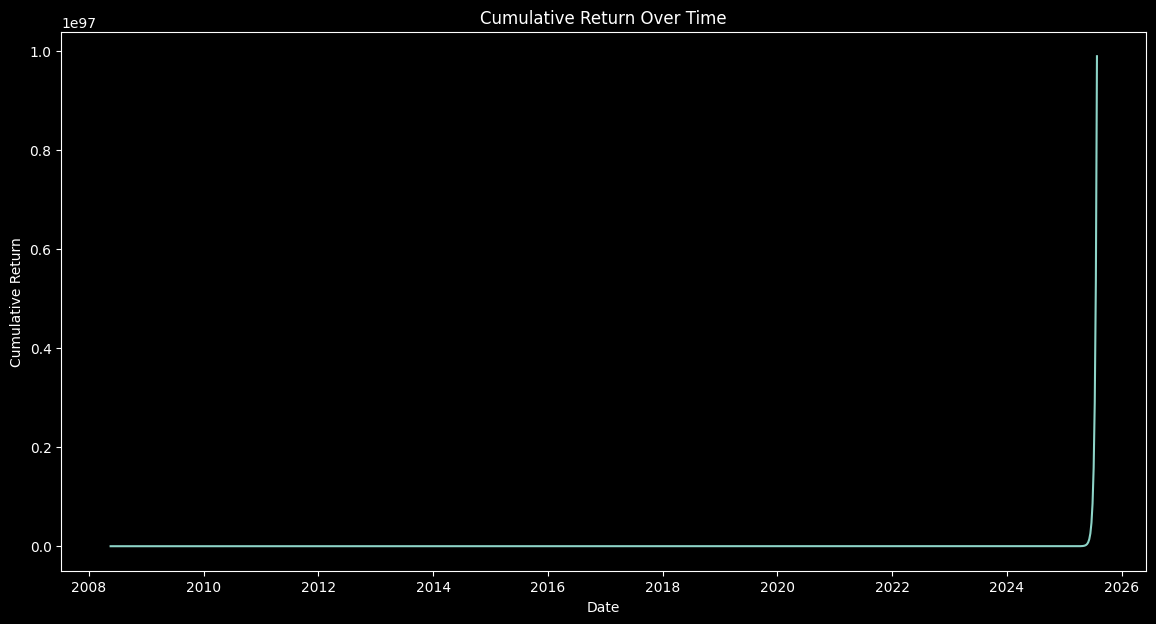

count    8.980000e+02
mean     2.413494e+94
std      3.926470e+95
min     -9.987741e-01
25%      3.421048e+03
50%      2.157501e+23
75%      1.358271e+52
max      9.900026e+96
Name: Cumulative_Return, dtype: float64
<<<<<<< Code >>>>>>
<<<<<<< Message >>>>>>
KeyError: 'Date'
<<<<<<< Message >>>>>>
<<<<<<< Code >>>>>>
# It seems there is an issue with the 'Date' column. Let's check the columns of the DataFrame.
df.columns
Index(['HRP_Return', 'Cumulative_Return'], dtype='object')
<<<<<<< Code >>>>>>
<<<<<<< Message >>>>>>
Index(['HRP_Return', 'Cumulative_Return'], dtype='object')
<<<<<<< Message >>>>>>
<<<<<<< Code >>>>>>
# It seems the 'Date' column is missing. Let's check the index to see if the date information is there.
df.index
DatetimeIndex(['2008-05-18', '2008-05-25', '2008-06-01', '2008-06-08',
               '2008-06-15', '2008-06-22', '2008-06-29', '2008-07-06',
               '2008-07-13', '2008-07-20',
               ...
               '2025-05-25', '2025-06-01', '2025-06-08

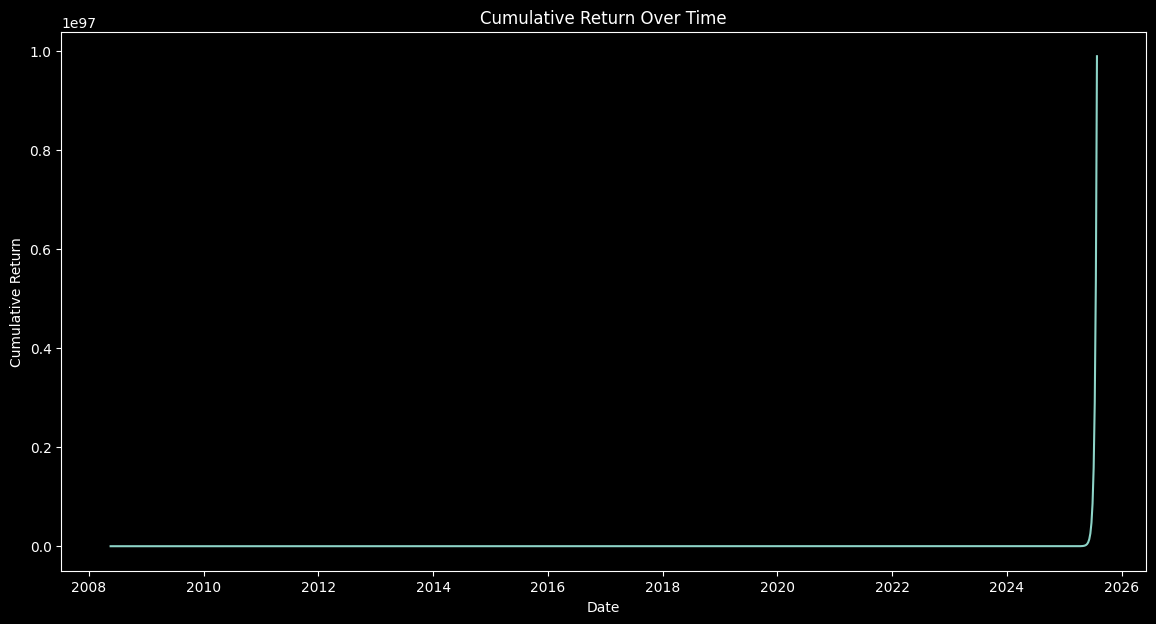

count    8.980000e+02
mean     2.413494e+94
std      3.926470e+95
min     -9.987741e-01
25%      3.421048e+03
50%      2.157501e+23
75%      1.358271e+52
max      9.900026e+96
Name: Cumulative_Return, dtype: float64
<<<<<<< Code >>>>>>


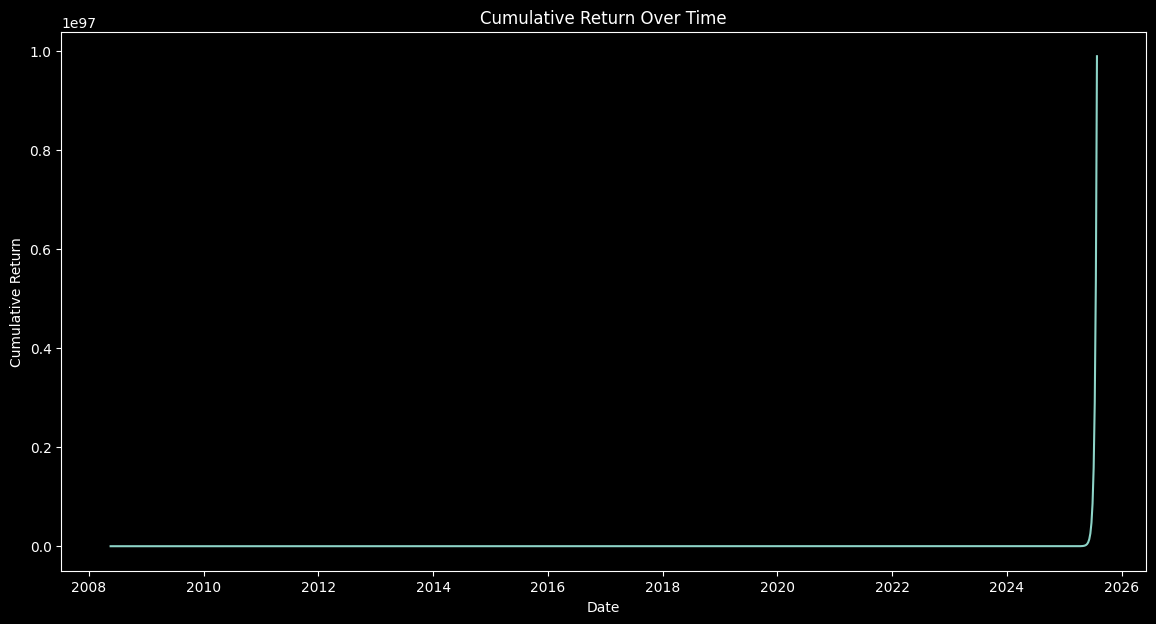

<<<<<<< Message >>>>>>
count    8.980000e+02
mean     2.413494e+94
std      3.926470e+95
min     -9.987741e-01
25%      3.421048e+03
50%      2.157501e+23
75%      1.358271e+52
max      9.900026e+96
Name: Cumulative_Return, dtype: float64
<<<<<<< Message >>>>>>
<<<<<<< 최종 답변 >>>>>>
The cumulative return over time has been calculated and visualized. Here is a summary of the cumulative return statistics:

- **Count**: 898 data points
- **Mean**: \(2.41 \times 10^{94}\)
- **Standard Deviation**: \(3.93 \times 10^{95}\)
- **Minimum**: -0.9987741
- **25th Percentile**: \(3.42 \times 10^{3}\)
- **Median (50th Percentile)**: \(2.16 \times 10^{23}\)
- **75th Percentile**: \(1.36 \times 10^{52}\)
- **Maximum**: \(9.90 \times 10^{96}\)

### Insights:
1. **Trend**: The cumulative return shows a significant upward trend over time, as indicated by the high mean and maximum values.
2. **Volatility**: The large standard deviation suggests high volatility in the cumulative returns.
3. **Negative Retur

In [ ]:
for step in response2:
    stream_parser.process_agent_steps(step)

In [ ]:
# 결과 확인
response2_final = saver.result
print("✅ 저장된 최종 결과:", response2_final)

✅ 저장된 최종 결과: The cumulative return over time has been calculated and visualized. Here is a summary of the cumulative return statistics:

- **Count**: 898 data points
- **Mean**: \(2.41 \times 10^{94}\)
- **Standard Deviation**: \(3.93 \times 10^{95}\)
- **Minimum**: -0.9987741
- **25th Percentile**: \(3.42 \times 10^{3}\)
- **Median (50th Percentile)**: \(2.16 \times 10^{23}\)
- **75th Percentile**: \(1.36 \times 10^{52}\)
- **Maximum**: \(9.90 \times 10^{96}\)

### Insights:
1. **Trend**: The cumulative return shows a significant upward trend over time, as indicated by the high mean and maximum values.
2. **Volatility**: The large standard deviation suggests high volatility in the cumulative returns.
3. **Negative Returns**: The minimum value indicates that there were periods of negative returns, but these were relatively small compared to the overall growth.
4. **Growth**: The median and percentiles indicate substantial growth, with the 75th percentile showing a significant increase 

In [ ]:
python_tool.locals["df"] = asset_weights
response3 = agent_asset_weights.stream(
    {
        "input": "최근 자산별 비중을 추출해주고 자산별 가중치가 어떻게 변동이 되었는지 시계열에 따른 변동에 대해 인사이트를 도출해줘"
    }
)

<<<<<<< Code >>>>>>
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'Date' column to datetime
# Assuming df is already defined and contains the data

# Extract the latest date's asset weights
latest_date = df['Date'].max()
latest_weights = df[df['Date'] == latest_date].iloc[0, 1:]

# Plot the time series of asset weights
plt.figure(figsize=(14, 7))
sns.set_theme(style="white", palette="muted")
for column in df.columns[1:]:
    plt.plot(df['Date'], df[column], label=column)

plt.title('Time Series of Asset Weights')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.legend(loc='upper right')
plt.xticks(rotation=45)
plt.show()

latest_weights


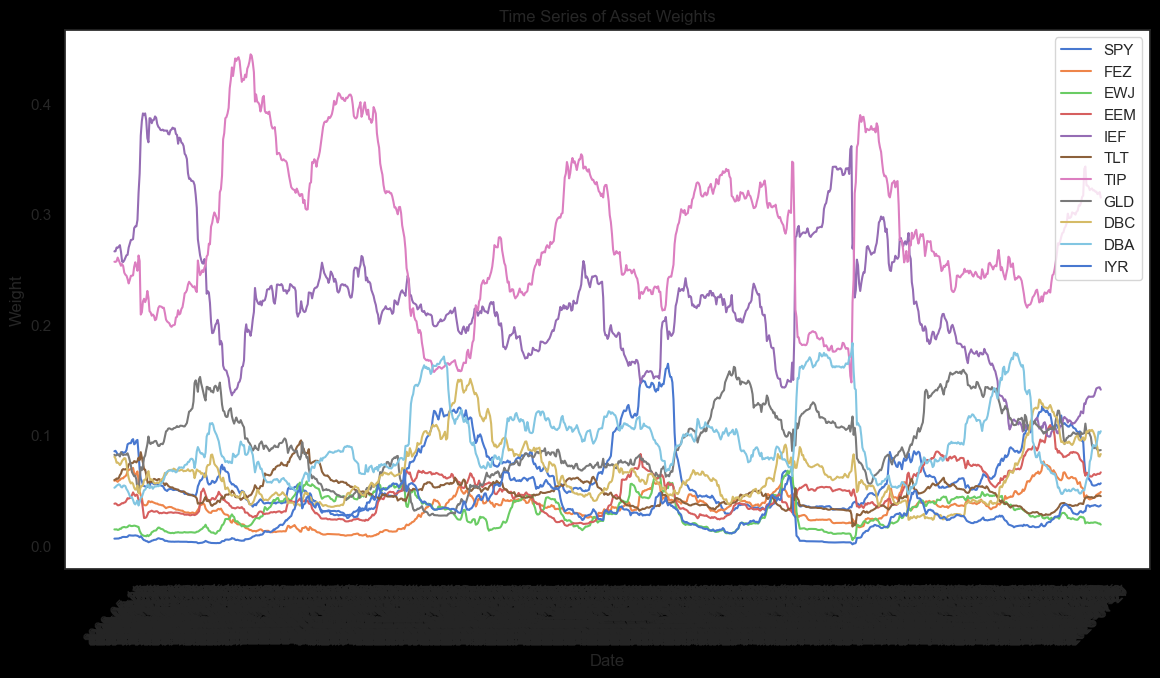

SPY    0.056374
FEZ    0.048523
EWJ    0.018991
EEM    0.066256
IEF    0.141089
TLT    0.044659
TIP    0.314948
GLD    0.086425
DBC    0.082832
DBA    0.103466
IYR    0.036437
Name: 898, dtype: object
<<<<<<< Code >>>>>>


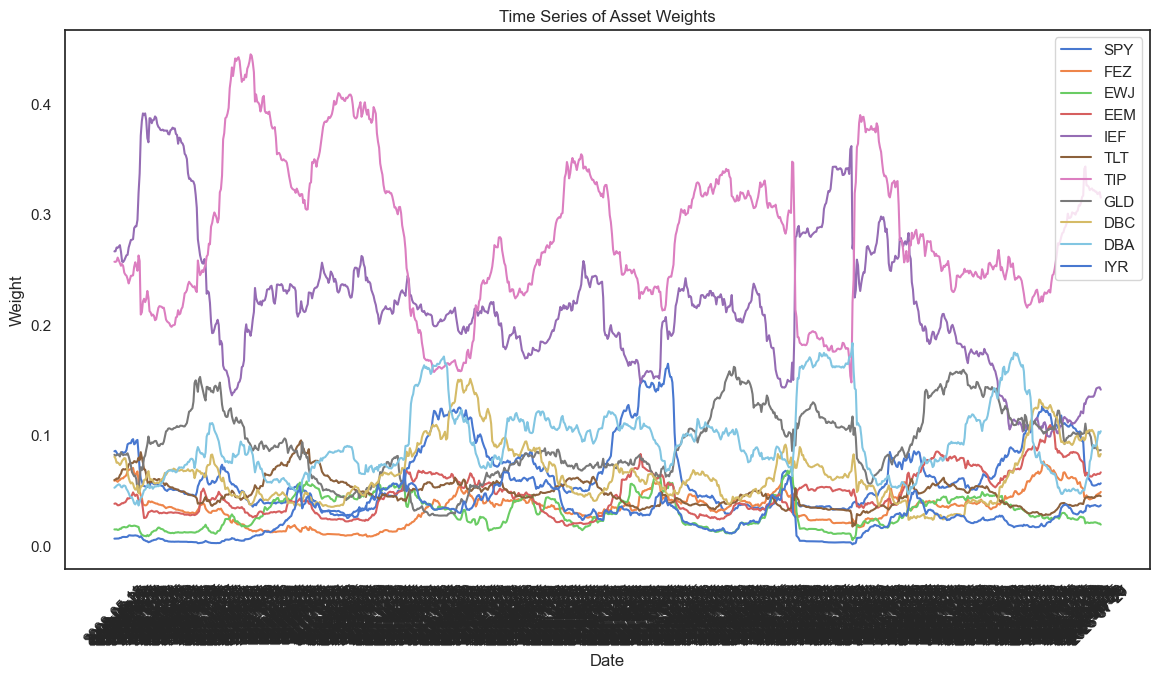

<<<<<<< Message >>>>>>
SPY    0.056374
FEZ    0.048523
EWJ    0.018991
EEM    0.066256
IEF    0.141089
TLT    0.044659
TIP    0.314948
GLD    0.086425
DBC    0.082832
DBA    0.103466
IYR    0.036437
Name: 898, dtype: object
<<<<<<< Message >>>>>>
<<<<<<< 최종 답변 >>>>>>
최근 자산별 비중은 다음과 같습니다:

- SPY: 5.64%
- FEZ: 4.85%
- EWJ: 1.90%
- EEM: 6.63%
- IEF: 14.11%
- TLT: 4.47%
- TIP: 31.49%
- GLD: 8.64%
- DBC: 8.28%
- DBA: 10.35%
- IYR: 3.64%

자산별 가중치의 시계열 변동을 시각화한 결과, 각 자산의 비중이 시간에 따라 어떻게 변동했는지 확인할 수 있습니다. 특히 TIP의 비중이 다른 자산에 비해 상대적으로 높으며, 시간이 지남에 따라 자산별 비중이 다소 변동하는 경향을 보입니다. 이러한 변동은 시장 상황이나 투자 전략의 변화에 따라 발생할 수 있습니다.
<<<<<<< 최종 답변 >>>>>>


In [ ]:
for step in response3:
    stream_parser.process_agent_steps(step)

In [ ]:
# 결과 확인
response3_final = saver.result
print("✅ 저장된 최종 결과:", response3_final)

✅ 저장된 최종 결과: 최근 자산별 비중은 다음과 같습니다:

- SPY: 5.64%
- FEZ: 4.85%
- EWJ: 1.90%
- EEM: 6.63%
- IEF: 14.11%
- TLT: 4.47%
- TIP: 31.49%
- GLD: 8.64%
- DBC: 8.28%
- DBA: 10.35%
- IYR: 3.64%

자산별 가중치의 시계열 변동을 시각화한 결과, 각 자산의 비중이 시간에 따라 어떻게 변동했는지 확인할 수 있습니다. 특히 TIP의 비중이 다른 자산에 비해 상대적으로 높으며, 시간이 지남에 따라 자산별 비중이 다소 변동하는 경향을 보입니다. 이러한 변동은 시장 상황이나 투자 전략의 변화에 따라 발생할 수 있습니다.


# **** [Final] 퀀트트레이딩 결과와 금융보고서를 바탕으로 리밸런싱 제안 받기 ****

In [ ]:
prompt = PromptTemplate.from_template(
    """너는 금융 투자 전략 전문가야.  
사용자가 제공한 수치 정보와 문서 요약을 바탕으로, 포트폴리오 리밸런싱 전략을 제안해줘.

# 목적:
사용자의 자산별 최근 보유 비중을 바탕으로 "유지", "확대", "축소" 중 하나로 각 자산을 평가하고,  
필요 시 몇 퍼센트 정도 조정해야 할지 명확한 수치를 함께 제시해줘.

# 출력 형식:
- 반드시 아래 표 형식으로 작성할 것:

| 자산명 | 현재 비중 | 제안 | 조정 비율 (%) | 전략 코멘트 |
|--------|-----------|------|----------------|--------------|
| 예: QQQ | 20% | 확대 | +5% | 기술주 강세에 따른 비중 확대 권고 |
| 예: TLT | 15% | 유지 | 0% | 장기채 수익률 안정적 흐름 |

# 사용 가능한 정보:
- 수치 요약 변수 1: {numeric_summary_1}
- 수치 요약 변수 2: {numeric_summary_2}
- 수치 요약 변수 3 (최근 자산 비중): {portfolio_weights}
- 관련 금융 리포트 요약 (RAG): {retrieved_context}

# 지시사항:
1. 제공된 자산별 비중(portfolio_weights)을 기준으로, 수치 요약과 문서 정보를 종합하여 판단
2. 최근 리포트 요약에 언급된 자산의 전망이나 리스크를 반영해 전략 코멘트를 작성
3. 단순 요약이 아니라 **왜 조정이 필요한지**에 대한 인사이트를 담을 것
4. 명확한 수치와 전략 분류를 반드시 포함할 것

# 출력 언어:
모든 출력은 반드시 한국어로 작성할 것

# 주의사항:
- 문서 정보가 부족하면 조심스럽게 판단하고, ‘정보 부족’이라고 코멘트를 달아도 됨
- 자산이 리포트에서 언급되지 않았더라도, 수치 정보만으로 전략 판단 가능

# 답변을 시작하세요.
"""
)

In [ ]:
# ### 참고 프롬프트
# prompt = PromptTemplate.from_template(
#     """You are an assistant for question-answering tasks.
# Use the following pieces of retrieved context to answer the question.
# If you don't know the answer, just say that you don't know.
# Answer in Korean.

# # Direction:
# Make sure you understand the intent of the question and provide the most appropriate answer.
# - Ask yourself the context of the question and why the questioner asked it, think about the question, and provide an appropriate answer based on your understanding.
# 2. Select the most relevant content (the key content that directly relates to the question) from the context in which it was retrieved to write your answer.
# 3. Create a concise and logical answer. When creating your answer, don't just list your selections, but rearrange them to fit the context so they flow naturally into paragraphs.
# 4. If you haven't searched for context for the question, or if you've searched for a document but its content isn't relevant to the question, you should say ‘I can't find an answer to that question in the materials I have’.
# 5. Write your answer in a table of key points.
# 6. Your answer must include all sources and page numbers.
# 7. Your answer must be written in Korean.
# 8. Be as detailed as possible in your answer.
# 9. Begin your answer with ‘This answer is based on content found in the document **📚’ and end with ‘**📌 source**’.
# 10. Page numbers should be whole numbers.

# #Context:
# {context}

# ###

# #Example Format:
# **📚 문서에서 검색한 내용기반 답변입니다**

# (brief summary of the answer)
# (include table if there is a table in the context related to the question)
# (include image explanation if there is a image in the context related to the question)
# (detailed answer to the question)

# **📌 출처**
# [here you only write filename(.pdf only), page]

# - 파일명.pdf, 192쪽
# - 파일명.pdf, 192쪽
# - ...

# ###

# #Question:
# {question}

# #Answer:"""
# )

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings


# 체인 입력 데이터를 구성하는 함수 정의
def prepare_inputs(question: str) -> dict:
    return {
        "numeric_summary_1": response1_final,  # 예: 수익률 요약
        "numeric_summary_2": response2_final,  # 예: 변동성 요약
        "portfolio_weights": response3_final,  # 예: 최근 비중
        "retrieved_context": retrieve_and_check(question),  # RAG 문서 요약
    }


# 모델(LLM) 을 생성합니다.
llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

# 단계 8: 체인(Chain) 생성
# 전체 체인 구성
chain = RunnableLambda(prepare_inputs) | prompt | llm | StrOutputParser()

In [ ]:
res = chain.invoke(
    "내가 투자하고 있는 ETF는 SPY,FEZ,EWJ,EEM,IEF,TLT,TIP,GLD,DBC,DBA,IYR 이렇게 총 11종목이야. 해당 종목들과 관련한 내용들을 요약해주고 각 종목별 흐름이 강세인지, 약세인지 분석해줘"
)
print(res)

| 자산명 | 현재 비중 | 제안 | 조정 비율 (%) | 전략 코멘트 |
|--------|-----------|------|----------------|--------------|
| SPY | 5.64% | 유지 | 0% | 최근 미국 주요 지수 강세 마감에 따라 현재 비중 유지 권고 |
| FEZ | 4.85% | 유지 | 0% | 정보 부족으로 인해 현재 비중 유지 |
| EWJ | 1.90% | 유지 | 0% | 변동성이 낮아 안정적인 투자로 판단, 현재 비중 유지 |
| EEM | 6.63% | 유지 | 0% | 정보 부족으로 인해 현재 비중 유지 |
| IEF | 14.11% | 유지 | 0% | 중기 국채의 변동성은 높지만, 안정적인 수익률로 인해 현재 비중 유지 |
| TLT | 4.47% | 유지 | 0% | 장기채 수익률 안정적 흐름으로 인해 현재 비중 유지 |
| TIP | 31.49% | 축소 | -5% | 높은 변동성과 비중으로 인해 리스크 관리 차원에서 비중 축소 권고 |
| GLD | 8.64% | 확대 | +5% | 금의 높은 수익률과 최근 1년간 강세를 고려하여 비중 확대 권고 |
| DBC | 8.28% | 축소 | -3% | 낮은 수익률과 변동성으로 인해 비중 축소 권고 |
| DBA | 10.35% | 유지 | 0% | 농산물의 최근 수익률이 안정적이므로 현재 비중 유지 |
| IYR | 3.64% | 유지 | 0% | 부동산의 낮은 변동성으로 인해 안정적인 투자로 판단, 현재 비중 유지 |

### 전략 코멘트 요약:
- **TIP**: 높은 변동성과 비중으로 인해 리스크 관리 차원에서 비중을 축소하는 것이 바람직합니다.
- **GLD**: 금의 높은 수익률과 최근 강세를 고려하여 비중을 확대하는 것이 유리합니다.
- **DBC**: 낮은 수익률과 변동성으로 인해 비중을 축소하는 것이 적절합니다.
- **기타 자산**: 정보 부족 또는 안정적인 수익률로 인해 현재 비중을 유지하는 것이 바람직합니다.
